#Utility functions, parameters, and Google Drive

In [ ]:
#@title General parameters { run: "auto", display-mode: "form" }
from torchvision import transforms
import PIL.Image

_nb_epochs = 100 #@param {type:"integer"}
_log_interval = 14 #@param {type:"integer"}
_dataset = "CIFAR-10" #@param ["ImageNet-16", "CIFAR-10", "CIFAR-100", "CINIC-10"]

_interpolation_method = "nearest" #@param ["nearest", "bilinear", "cubic"]
if "nearest" == _interpolation_method:
    _interpolation_method = PIL.Image.NEAREST
elif "bilinear" == _interpolation_method:
    _interpolation_method = PIL.Image.BILINEAR
elif "cubic" == _interpolation_method:
    _interpolation_method = PIL.Image.CUBIC
    
_transformations = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [ ]:
#@title SqueezeNet parameters

_squeeze_enabled = True #@param {type:"boolean"}
_squeeze_learning_rate = 0.005 #@param {type:"number"}
_squeeze_momentum = 0.1 #@param {type:"number"}
_squeeze_step_size=20 #@param {type:"number"}
_squeeze_gamma = 0.1 #@param {type:"number"}
_squeeze_weight_decay=0 #@param {type:"number"}
_squeeze_pretrained = False #@param {type:"boolean"}

In [ ]:
#@title Second parameters

_second_version = "ablation_1" #@param ["squeeze1.0", "ablation_1", "ablation_2", "ablation_3", "ablation_4", "expansion_1"]
_second_learning_rate = 0.005 #@param {type:"number"}
_second_momentum = 0.1 #@param {type:"number"}
_second_step_size=20 #@param {type:"number"}
_second_gamma = 0.1 #@param {type:"number"}
_second_weight_decay=0 #@param {type:"number"}


In [ ]:
#@title Google Drive {run: "auto"}
from google.colab import drive

drive.mount('/gdrive', force_remount=True)
data_folder = '/gdrive/My Drive/COMP551_Assignment3_data/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
#@title Utility functions

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display
    
    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)
        
    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
                    
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

def try_makedirs(d):
    import os
    try:
        os.makedirs(d)
    except FileExistsError as e:
        pass

def load_image(filename):
    return \
        PIL.Image.open(filename)\
          .resize((64,64), _interpolation_method)\
          .convert('RGB')

# def load_image(filename):
#     return np.array(
#         PIL.Image.open(filename)\
#           .resize((64,64), _interpolation_method)\
#           .convert('RGB'),
#         dtype=np.float32
#     )/255

def plot_results(squeeze_results, sec_results):
    import matplotlib.pyplot as plt
    
    x = range(1, 1+sec_results.shape[0])
    squeeze_plt = plt.plot(x, squeeze_results[:,1], 'b-', x, squeeze_results[:,1], 'bo')
    sec_plt = plt.plot(x, sec_results[:,1], 'g-', x, sec_results[:,1], 'go')
    
    for i in range(1, _nb_epochs):
        if sec_results[i,2] != sec_results[i-1,2] \
          and not np.isnan(sec_results[i,2]) \
          and not np.isnan(sec_results[i-1, 2]):
            plt.plot([i-0.1, i-0.01], [0, 100], 'g--')
        if squeeze_results[i,2] != squeeze_results[i-1,2] \
          and not np.isnan(squeeze_results[i,2]) \
          and not np.isnan(squeeze_results[i-1, 2]):
            plt.plot([i+0.1, i+0.01], [0, 100], 'b--')

    plt.legend((squeeze_plt[0], sec_plt[0]), ('SqueezeNet', 'Second'))
    plt.title('Model accuracy improvement over time')
    plt.xlabel('# of epochs')
    plt.xticks(np.linspace(1, sec_results.shape[0], 11))
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    plt.yticks(np.linspace(0, 100, 11));
    plt.draw()   

    
def plot_results_to_grid(grid, where, sec_results, squeeze_results):
    import matplotlib.pyplot as plt
    
    with grid.output_to(where[0], where[1]):
        grid.clear_cell()
        plot_results(squeeze_results, sec_results)

        
def elapsed_time(model_name, i):
    import time
    
    if 0 == i:
        elapsed_time.start = time.time()
    else:
        print(
            "{{{}}} The last training epoch took {} seconds.\n\n".format(
                model_name, time.time() - elapsed_time.start
            )
        )
        

class CatchIO:
    def __init__(self):
        self._stdout = None
        self.buffer = None
    
    def __enter__(self):
        import sys
        import io
        
        self._stdout = sys.stdout
        sys.stdout = io.StringIO()
    
    def __exit__(self, type_, value, traceback):
        import sys
        
        self.buffer = sys.stdout.getvalue()
        sys.stdout = self._stdout
        if value is not None:
            raise value


#Models and datasets

In [ ]:
#@title SqueezeNet {display-mode: "form"}
import torchvision.models.squeezenet
import torch.nn as nn
import torch.nn.functional as F

class SqueezeNet(nn.Module):
  
    def __init__(self):
        super(SqueezeNet, self).__init__()
        self.squeeze = torchvision.models.squeezenet.squeezenet1_0(pretrained=_squeeze_pretrained, num_classes=1000);
   
    def forward(self, x):
        return F.log_softmax(self.squeeze.forward(x), dim=1)

In [ ]:
#@title Second
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo


__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']


model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class Second(nn.Module):

    def __init__(self, version=1.0, num_classes=1000):
        super(Second, self).__init__()
        self.num_classes = num_classes
        if "squeeze1.0" == version:
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif "ablation_1" == version:
            # Ablation 1: Remove last Fire module: Fire(512, 64, 256, 256)
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            )
        elif "ablation_2" == version:
            # Ablation 2: Remove before to last Fire module: Fire(384, 64, 256, 256)
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(384, 64, 256, 256),
            )
        elif "ablation_3" == version:
            # Ablation 3: Normal, except "classifier" is initialized like the
            # rest of the model.
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif "expansion_1" == version:
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        else:
            raise ValueError("Unsupported version {version}".format(version=version))
        
        # Final convolution is initialized differently form the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv and "ablation_3" != version:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return F.log_softmax(x.view(x.size(0), self.num_classes), dim=1)


In [ ]:
#@title ImageNet-16 _(warning: very slow)_
from torchvision.datasets import DatasetFolder

from zipfile import ZipFile
import os
import pandas
import PIL.Image
import numpy as np

path_to_ImageNet16 = "Gdata/" #@param {type:"string"}

if "ImageNet-16" == _dataset:
    IMGSZ = (16,16,3)
    NUM_IMAGES = 1275273

    train_pickle_folder = 'data/16/train/pickle'
    train_image_folder = 'data/16/train/images'
    valid_image_folder = 'data/16/validation/images'
    test_pickle_folder = 'data/16/test/pickle'
    test_image_folder = 'data/16/test/images'

    force = False #@param {type:"boolean"}
    train_valid_split = 0.9 #@param {type:"slider", min:0, max:1, step:0.05}

    ct = np.zeros(1000)

    if not os.path.exists(train_image_folder) or force:
        # Create folders
        try_makedirs(train_pickle_folder)
        try_makedirs(train_image_folder)
        try_makedirs(valid_image_folder)
        try_makedirs(test_pickle_folder)
        try_makedirs(test_image_folder)
        for ix in range(1000):
            try_makedirs(os.path.join(train_image_folder, "class_{}".format(1+ix)))
            try_makedirs(os.path.join(valid_image_folder, "class_{}".format(1+ix)))
            try_makedirs(os.path.join(test_image_folder, "class_{}".format(1+ix)))
        # Extract training data zipfile
        z = ZipFile(
            os.path.join(
                '/gdrive/My Drive/', path_to_ImageNet16, 'Imagenet16_train.zip'
            )
        )
        z.extractall(train_pickle_folder)
        z.close()
        # Extract training images to folders
        for ix in log_progress(
            range(1, 11), every=1, name="Converting pickle files to images"
        ):
            # Read pickle
            tmp = pandas.read_pickle(
                os.path.join(train_pickle_folder, 'train_data_batch_{}'.format(ix))
            )
            # CIFAR format to array of images
            train_images = tmp['data'] \
              .reshape(-1, IMGSZ[2], IMGSZ[0], IMGSZ[1]) \
              .transpose([0, 2, 3, 1])
            # Save images to png (lossless format)
            for jx in range(len(train_images)):
                label = tmp['labels'][jx]
                # Split training set into training and validation sets
                if ct[label-1] > np.floor(train_valid_split * NUM_IMAGES / 1000):
                    # validation
                    out_folder = valid_image_folder
                else:
                    # training
                    out_folder = train_image_folder
                    ct[label-1] = 1 + ct[label-1]
                # Save
                PIL.Image.fromarray(train_images[jx]).save(
                    os.path.join(
                        out_folder,
                        'class_{}'.format(label),
                        '{}.png'.format(jx)
                    )
                )
            # Remove pickle file since we're done with it
            os.remove(
                os.path.join(train_pickle_folder, 'train_data_batch_{}'.format(ix))
            )

        # Extract test data zipfile
        z = ZipFile(
            os.path.join(
                '/gdrive/My Drive/', path_to_ImageNet16, 'Imagenet16_val.zip'
            )
        )
        z.extractall(test_pickle_folder)
        z.close()
        # Extract test images to folders
        #   Read pickle
        tmp = pandas.read_pickle(os.path.join(test_pickle_folder, 'val_data'))
        #   CIFAR format to array of images
        test_images = tmp['data'] \
          .reshape(-1, IMGSZ[2], IMGSZ[0], IMGSZ[1]) \
          .transpose([0, 2, 3, 1])
        #   Save images to png (lossless format)
        for jx in range(len(test_images)):
            # Save
            PIL.Image.fromarray(test_images[jx]).save(
                os.path.join(
                    test_image_folder,
                    'class_{}'.format(tmp['labels'][jx]),
                    '{}.png'.format(jx)
                )
            )
        #   Remove pickle file since we're done with it
        os.remove(
            os.path.join(test_pickle_folder, 'val_data')
        )

    trainset = DatasetFolder(
        train_image_folder, load_image, ['png'],
        transform=_transformations
    )
    validset = DatasetFolder(
        valid_image_folder, load_image, ['png'],
        transform=_transformations
    )
    testset = DatasetFolder(
        test_image_folder, load_image, ['png'],
        transform=_transformations
    )

else:
    print('Disabled')


RuntimeError: ignored

In [ ]:
#@title CIFAR-10
from torchvision.datasets import DatasetFolder
import tarfile
import os
import pandas
import PIL.Image
import numpy as np

path_to_CIFAR10 = "Gdata/" #@param {type:"string"}

if "CIFAR-10" == _dataset:
    IMGSZ = (32, 32, 3)
    NUM_IMAGES = 50000
    NUM_CLASSES = 10

    pickle_folder = 'data/CIFAR10/pickle'
    train_image_folder = 'data/CIFAR10/train/images'
    valid_image_folder = 'data/CIFAR10/validation/images'
    test_image_folder = 'data/CIFAR10/test/images'

    force = False #@param {type:"boolean"}
    train_valid_split = 0.9 #@param {type:"slider", min:0, max:1, step:0.05}

    ct = np.zeros(NUM_CLASSES)

    if not os.path.exists(train_image_folder) or force:
        # Create folders
        try_makedirs(pickle_folder)
        try_makedirs(train_image_folder)
        try_makedirs(valid_image_folder)
        try_makedirs(test_image_folder)
        for ix in range(NUM_CLASSES):
            try_makedirs(os.path.join(train_image_folder, "class_{}".format(ix)))
            try_makedirs(os.path.join(valid_image_folder, "class_{}".format(ix)))
            try_makedirs(os.path.join(test_image_folder, "class_{}".format(ix)))
        # Extract training data zipfile
        tar = tarfile.open(
            os.path.join(
                '/gdrive/My Drive/', path_to_CIFAR10, 'cifar-10-python.tar.gz'
            )
        )
        tar.extractall(pickle_folder)
        tar.close()
        # Extract training images to folders
        for ix in log_progress(
            range(1, 6), every=1, name="Converting pickle files to images"
        ):
            # Read pickle
            tmp = pandas.read_pickle(
                os.path.join(
                    pickle_folder, 'cifar-10-batches-py', 'data_batch_{}'.format(ix)
                )
            )
            # CIFAR format to array of images
            train_images = tmp['data'] \
              .reshape(-1, IMGSZ[2], IMGSZ[0], IMGSZ[1]) \
              .transpose([0, 2, 3, 1])
            # Save images to png (lossless format)
            for jx in range(len(train_images)):
                label = tmp['labels'][jx]
                # Split training set into training and validation sets
                if ct[label-1] > np.floor(train_valid_split * NUM_IMAGES / NUM_CLASSES):
                    # validation
                    out_folder = valid_image_folder
                else:
                    # training
                    out_folder = train_image_folder
                    ct[label-1] = 1 + ct[label-1]
                # Save
                PIL.Image.fromarray(train_images[jx]).save(
                    os.path.join(
                        out_folder,
                        'class_{}'.format(label),
                        '{}.png'.format(jx)
                    )
                )
            # Remove pickle file since we're done with it
            os.remove(
                os.path.join(
                    pickle_folder,
                    'cifar-10-batches-py', 
                    'data_batch_{}'.format(ix)
                )
            )

        # Extract test images to folders
        #   Read pickle
        tmp = pandas.read_pickle(
            os.path.join(pickle_folder, 'cifar-10-batches-py', 'test_batch')
        )
        #   CIFAR format to array of images
        test_images = tmp['data']\
          .reshape(-1, IMGSZ[2], IMGSZ[0], IMGSZ[1]) \
          .transpose([0, 2, 3, 1])
        #   Save images to png (lossless format)
        for jx in range(len(test_images)):
            # Save
            PIL.Image.fromarray(test_images[jx]).save(
                os.path.join(
                    test_image_folder,
                    'class_{}'.format(tmp['labels'][jx]),
                    '{}.png'.format(jx)
                )
            )
        #   Remove pickle file since we're done with it
        os.remove(
            os.path.join(pickle_folder, 'cifar-10-batches-py', 'test_batch')
        )
    trainset = DatasetFolder(
        train_image_folder, load_image, ['png'],
        transform=_transformations
    )
    validset = DatasetFolder(
        valid_image_folder, load_image, ['png'],
        transform=_transformations
    )
    testset = DatasetFolder(
        test_image_folder, load_image, ['png'],
        transform=_transformations
    )
  
    print('done')  
    
else:
    print('Disabled')

done


In [ ]:
#@title CIFAR-100
from torchvision.datasets import DatasetFolder
import tarfile
import os
import pandas
import PIL.Image
import numpy as np

path_to_CIFAR100 = "Gdata/" #@param {type:"string"}

if "CIFAR-100" == _dataset:
    print('Loading CIFAR-100... ', end='')
    
    IMGSZ = (32, 32, 3)
    NUM_IMAGES = 50000
    NUM_CLASSES = 100

    pickle_folder = 'data/CIFAR100/pickle'
    train_image_folder = 'data/CIFAR100/train/images'
    valid_image_folder = 'data/CIFAR100/validation/images'
    test_image_folder = 'data/CIFAR100/test/images'

    label_type = "fine (100)" #@param ["fine (100)", "coarse (20)"]
    if label_type == "fine (100)":
        label_type = "fine_labels"
        _dataset = "CIFAR-100_100"
    elif label_type == "coarse (20)":
        label_type = "coarse_labels"
        _dataset = "CIFAR-100_20"
    
    force = True #@param {type:"boolean"}
    train_valid_split = 0.9 #@param {type:"slider", min:0, max:1, step:0.05}

    ct = np.zeros(NUM_CLASSES)

    if not os.path.exists(train_image_folder) or force:
        # Create folders
        try_makedirs(pickle_folder)
        try_makedirs(train_image_folder)
        try_makedirs(valid_image_folder)
        try_makedirs(test_image_folder)
        for ix in range(NUM_CLASSES):
            try_makedirs(os.path.join(train_image_folder, "class_{}".format(ix)))
            try_makedirs(os.path.join(valid_image_folder, "class_{}".format(ix)))
            try_makedirs(os.path.join(test_image_folder, "class_{}".format(ix)))
        # Extract training data zipfile
        tar = tarfile.open(
            os.path.join(
                '/gdrive/My Drive/', path_to_CIFAR100, 'cifar-100-python.tar.gz'
            )
        )
        tar.extractall(pickle_folder)
        tar.close()
        # Extract training images to folders
        # Read pickle
        tmp = pandas.read_pickle(
            os.path.join(pickle_folder, 'cifar-100-python', 'train')
        )
        tmp.keys()
        # CIFAR format to array of images
        train_images = tmp['data'] \
          .reshape(-1, IMGSZ[2], IMGSZ[0], IMGSZ[1]) \
          .transpose([0, 2, 3, 1])
        # Save images to png (lossless format)
        for jx in range(len(train_images)):
            label = tmp[label_type][jx]
            # Split training set into training and validation sets
            if ct[label-1] > np.floor(train_valid_split * NUM_IMAGES / NUM_CLASSES):
                # validation
                out_folder = valid_image_folder
            else:
                # training
                out_folder = train_image_folder
                ct[label-1] = 1 + ct[label-1]
            # Save
            PIL.Image.fromarray(train_images[jx]).save(
                os.path.join(
                    out_folder,
                    'class_{}'.format(label),
                    '{}.png'.format(jx)
                )
            )
        # Remove pickle file since we're done with it
        os.remove(os.path.join(pickle_folder, 'cifar-100-python', 'train'))

        # Extract test images to folders
        #   Read pickle
        tmp = pandas.read_pickle(
            os.path.join(pickle_folder, 'cifar-100-python', 'test')
        )
        #   CIFAR format to array of images
        test_images = tmp['data']\
          .reshape(-1, IMGSZ[2], IMGSZ[0], IMGSZ[1]) \
          .transpose([0, 2, 3, 1])
        #   Save images to png (lossless format)
        for jx in range(len(test_images)):
            # Save
            PIL.Image.fromarray(test_images[jx]).save(
                os.path.join(
                    test_image_folder,
                    'class_{}'.format(tmp[label_type][jx]),
                    '{}.png'.format(jx)
                )
            )
        #   Remove pickle file since we're done with it
        os.remove(
            os.path.join(pickle_folder, 'cifar-100-python', 'test')
        )
    
    trainset = DatasetFolder(
        train_image_folder, load_image, ['png'],
        transform=_transformations
    )
    validset = DatasetFolder(
        valid_image_folder, load_image, ['png'],
        transform=_transformations
    )
    testset = DatasetFolder(
        test_image_folder, load_image, ['png'],
        transform=_transformations
    )
    
    print('Done.')
    
else:
    print('Disabled')

Loading CIFAR-100... 

FileNotFoundError: ignored

In [ ]:
#@title CINIC-10
from torchvision.datasets import ImageFolder
import tarfile
import os

path_to_CINIC = "Gdata/" #@param {type:"string"}
force = False #@param {type:"boolean"}
image_folder = 'data/CINIC-10'

if "CINIC-10" == _dataset:
    print('Loading CIFAR-100... ', end='')

    if not os.path.exists(image_folder) or force:
        tar = tarfile.open(os.path.join('/gdrive/My Drive/', path_to_CINIC))
        try_makedirs(image_folder)
        tar.extractall(image_folder)
        tar.close()

    trainset = ImageFolder(
        os.path.join(image_folder, 'train'),
        loader=load_image,
        transform=_transformations
    )
    validset = ImageFolder(
        os.path.join(image_folder, 'valid'),
        loader=load_image,
        transform=_transformations
    )
    testset = ImageFolder(
        os.path.join(image_folder, 'test'),
        loader=load_image,
        transform=_transformations
    )
    
    print('done')

else:
    print('Disabled')

Disabled


In [ ]:
#@title Dataloader and model initialization
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch

import PIL.Image


def train(model, model_name, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % _log_interval == 0:
            print('{{{}}} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    model_name, epoch, batch_idx * len(data),
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()
                )
            )


def validate(model, model_name, device, validation_loader):
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            validation_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(validation_loader.dataset)

    print(
        '\n{{{}}} Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
        .format(
            model_name, validation_loss, correct,
            len(validation_loader.dataset),
            100. * correct / len(validation_loader.dataset)
        )
    )

    return validation_loss, 100. * correct / len(validation_loader.dataset)


def test(model, model_name, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        '\n{{{}}} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
        .format(
            model_name, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)
        )
    )

    return test_loss, 100. * correct / len(test_loader.dataset)


torch.manual_seed(1)

# Initialize training, validation, and test loaders
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
valid_loader = DataLoader(validset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

# Initialize SqueezeNet
squeeze = SqueezeNet().to("cuda")
squeeze_opt = optim.SGD(
    squeeze.parameters(), lr=_squeeze_learning_rate, momentum=_squeeze_momentum,
    weight_decay=_squeeze_weight_decay
)
#squeeze_sch = optim.lr_scheduler.StepLR(squeeze_opt, _squeeze_step_size, _squeeze_gamma)
squeeze_sch = optim.lr_scheduler.ReduceLROnPlateau(squeeze_opt, factor=0.5, patience=2, verbose=True)

# Initialize Second
sec = Second(_second_version).to("cuda")
sec_opt = optim.Adam(
    sec.parameters(), lr=_second_learning_rate,
    weight_decay=_second_weight_decay
)
#sec_sch = optim.lr_scheduler.StepLR(sec_opt, _sec_step_size, _sec_gamma)
sec_sch = optim.lr_scheduler.ReduceLROnPlateau(sec_opt, factor=0.5, patience=2, verbose=True)



# Done!
print('Dataloaders and models initialized.')

Dataloaders and models initialized.


37821 4990 0.8834411716614888 10000


Text(0.5, 1.0, 'test set')

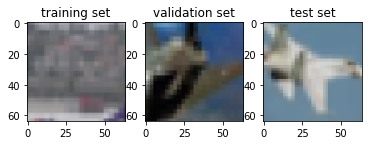

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print(
    len(trainset),
    len(validset),
    len(trainset) / (len(trainset) + len(validset)),
    len(testset)
)

plt.subplot(1, 3, 1)
plt.imshow(trainset[0][0].numpy().transpose([1, 2, 0]))
plt.title('training set')

plt.subplot(1, 3, 2)
plt.imshow(validset[0][0].numpy().transpose([1, 2, 0]))
plt.title('validation set')

plt.subplot(1, 3, 3)
plt.imshow(testset[0][0].numpy().transpose([1, 2, 0]))
plt.title('test set')


#Grid search


""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 1 [0/37821 (0%)]	Loss: 6.931210
{SqueezeNet} Train Epoch: 1 [896/37821 (2%)]	Loss: 4.404560
{SqueezeNet} Train Epoch: 1 [1792/37821 (5%)]	Loss: 3.302124
{SqueezeNet} Train Epoch: 1 [2688/37821 (7%)]	Loss: 2.377586
{SqueezeNet} Train Epoch: 1 [3584/37821 (9%)]	Loss: 2.372211
{SqueezeNet} Train Epoch: 1 [4480/37821 (12%)]	Loss: 2.648819
{SqueezeNet} Train Epoch: 1 [5376/37821 (14%)]	Loss: 2.576461
{SqueezeNet} Train Epoch: 1 [6272/37821 (17%)]	Loss: 2.402925
{SqueezeNet} Train Epoch: 1 [7168/37821 (19%)]	Loss: 2.322512
{SqueezeNet} Train Epoch: 1 [8064/37821 (21%)]	Loss: 2.438258
{SqueezeNet} Train Epoch: 1 [8960/37821 (24%)]	Loss: 2.378890
{SqueezeNet} Train Epoch: 1 [9856/37821 (26%)]	Loss: 2.382130
{SqueezeNet} Train Epoch: 1 [10752/37821 (28%)]	Loss: 2.384811
{SqueezeNet} Train Epoch: 1 [11648/37821 (31%)]	Loss: 2.335552
{SqueezeNet} Train Epoch: 1 [12544/37821 (33%)]	Loss: 2.431461
{SqueezeNet} Train Epoch: 1 [13440/37821 (36%)]	Loss: 2.351217
{SqueezeNet} 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 2 [0/37821 (0%)]	Loss: 2.143453
{SqueezeNet} Train Epoch: 2 [896/37821 (2%)]	Loss: 2.086438
{SqueezeNet} Train Epoch: 2 [1792/37821 (5%)]	Loss: 2.075742
{SqueezeNet} Train Epoch: 2 [2688/37821 (7%)]	Loss: 2.231920
{SqueezeNet} Train Epoch: 2 [3584/37821 (9%)]	Loss: 2.052154
{SqueezeNet} Train Epoch: 2 [4480/37821 (12%)]	Loss: 2.049055
{SqueezeNet} Train Epoch: 2 [5376/37821 (14%)]	Loss: 2.153385
{SqueezeNet} Train Epoch: 2 [6272/37821 (17%)]	Loss: 2.044766
{SqueezeNet} Train Epoch: 2 [7168/37821 (19%)]	Loss: 2.302118
{SqueezeNet} Train Epoch: 2 [8064/37821 (21%)]	Loss: 2.134369
{SqueezeNet} Train Epoch: 2 [8960/37821 (24%)]	Loss: 2.119457
{SqueezeNet} Train Epoch: 2 [9856/37821 (26%)]	Loss: 1.919463
{SqueezeNet} Train Epoch: 2 [10752/37821 (28%)]	Loss: 1.974909
{SqueezeNet} Train Epoch: 2 [11648/37821 (31%)]	Loss: 2.218530
{SqueezeNet} Train Epoch: 2 [12544/37821 (33%)]	Loss: 2.110519
{SqueezeNet} Train Epoch: 2 [13440/37821 (36%)]	Loss: 2.085514
{SqueezeNet} 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 3 [0/37821 (0%)]	Loss: 1.860294
{SqueezeNet} Train Epoch: 3 [896/37821 (2%)]	Loss: 2.049281
{SqueezeNet} Train Epoch: 3 [1792/37821 (5%)]	Loss: 2.076342
{SqueezeNet} Train Epoch: 3 [2688/37821 (7%)]	Loss: 2.064548
{SqueezeNet} Train Epoch: 3 [3584/37821 (9%)]	Loss: 1.967870
{SqueezeNet} Train Epoch: 3 [4480/37821 (12%)]	Loss: 2.118999
{SqueezeNet} Train Epoch: 3 [5376/37821 (14%)]	Loss: 2.077581
{SqueezeNet} Train Epoch: 3 [6272/37821 (17%)]	Loss: 2.049390
{SqueezeNet} Train Epoch: 3 [7168/37821 (19%)]	Loss: 1.880244
{SqueezeNet} Train Epoch: 3 [8064/37821 (21%)]	Loss: 1.872333
{SqueezeNet} Train Epoch: 3 [8960/37821 (24%)]	Loss: 1.886224
{SqueezeNet} Train Epoch: 3 [9856/37821 (26%)]	Loss: 2.182878
{SqueezeNet} Train Epoch: 3 [10752/37821 (28%)]	Loss: 2.018395
{SqueezeNet} Train Epoch: 3 [11648/37821 (31%)]	Loss: 1.935343
{SqueezeNet} Train Epoch: 3 [12544/37821 (33%)]	Loss: 1.902087
{SqueezeNet} Train Epoch: 3 [13440/37821 (36%)]	Loss: 1.983876
{SqueezeNet} 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 4 [0/37821 (0%)]	Loss: 2.042289
{SqueezeNet} Train Epoch: 4 [896/37821 (2%)]	Loss: 1.990417
{SqueezeNet} Train Epoch: 4 [1792/37821 (5%)]	Loss: 1.831069
{SqueezeNet} Train Epoch: 4 [2688/37821 (7%)]	Loss: 1.952723
{SqueezeNet} Train Epoch: 4 [3584/37821 (9%)]	Loss: 1.946364
{SqueezeNet} Train Epoch: 4 [4480/37821 (12%)]	Loss: 2.017955
{SqueezeNet} Train Epoch: 4 [5376/37821 (14%)]	Loss: 1.810403
{SqueezeNet} Train Epoch: 4 [6272/37821 (17%)]	Loss: 1.872723
{SqueezeNet} Train Epoch: 4 [7168/37821 (19%)]	Loss: 2.014799
{SqueezeNet} Train Epoch: 4 [8064/37821 (21%)]	Loss: 2.097281
{SqueezeNet} Train Epoch: 4 [8960/37821 (24%)]	Loss: 1.831434
{SqueezeNet} Train Epoch: 4 [9856/37821 (26%)]	Loss: 1.895758
{SqueezeNet} Train Epoch: 4 [10752/37821 (28%)]	Loss: 2.039958
{SqueezeNet} Train Epoch: 4 [11648/37821 (31%)]	Loss: 1.965899
{SqueezeNet} Train Epoch: 4 [12544/37821 (33%)]	Loss: 1.811878
{SqueezeNet} Train Epoch: 4 [13440/37821 (36%)]	Loss: 2.008544
{SqueezeNet} 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 5 [0/37821 (0%)]	Loss: 1.985518
{SqueezeNet} Train Epoch: 5 [896/37821 (2%)]	Loss: 1.919753
{SqueezeNet} Train Epoch: 5 [1792/37821 (5%)]	Loss: 2.001040
{SqueezeNet} Train Epoch: 5 [2688/37821 (7%)]	Loss: 2.005463
{SqueezeNet} Train Epoch: 5 [3584/37821 (9%)]	Loss: 1.939475
{SqueezeNet} Train Epoch: 5 [4480/37821 (12%)]	Loss: 1.954179
{SqueezeNet} Train Epoch: 5 [5376/37821 (14%)]	Loss: 1.871664
{SqueezeNet} Train Epoch: 5 [6272/37821 (17%)]	Loss: 1.907971
{SqueezeNet} Train Epoch: 5 [7168/37821 (19%)]	Loss: 1.958055
{SqueezeNet} Train Epoch: 5 [8064/37821 (21%)]	Loss: 2.176154
{SqueezeNet} Train Epoch: 5 [8960/37821 (24%)]	Loss: 1.909454
{SqueezeNet} Train Epoch: 5 [9856/37821 (26%)]	Loss: 1.944042
{SqueezeNet} Train Epoch: 5 [10752/37821 (28%)]	Loss: 1.708412
{SqueezeNet} Train Epoch: 5 [11648/37821 (31%)]	Loss: 2.023181
{SqueezeNet} Train Epoch: 5 [12544/37821 (33%)]	Loss: 1.848067
{SqueezeNet} Train Epoch: 5 [13440/37821 (36%)]	Loss: 1.703003
{SqueezeNet} 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 6 [0/37821 (0%)]	Loss: 1.868476
{SqueezeNet} Train Epoch: 6 [896/37821 (2%)]	Loss: 1.727426
{SqueezeNet} Train Epoch: 6 [1792/37821 (5%)]	Loss: 1.694404
{SqueezeNet} Train Epoch: 6 [2688/37821 (7%)]	Loss: 1.867685
{SqueezeNet} Train Epoch: 6 [3584/37821 (9%)]	Loss: 1.787597
{SqueezeNet} Train Epoch: 6 [4480/37821 (12%)]	Loss: 1.929323
{SqueezeNet} Train Epoch: 6 [5376/37821 (14%)]	Loss: 1.730799
{SqueezeNet} Train Epoch: 6 [6272/37821 (17%)]	Loss: 1.863935
{SqueezeNet} Train Epoch: 6 [7168/37821 (19%)]	Loss: 1.841340
{SqueezeNet} Train Epoch: 6 [8064/37821 (21%)]	Loss: 1.807414
{SqueezeNet} Train Epoch: 6 [8960/37821 (24%)]	Loss: 2.015309
{SqueezeNet} Train Epoch: 6 [9856/37821 (26%)]	Loss: 2.014957
{SqueezeNet} Train Epoch: 6 [10752/37821 (28%)]	Loss: 1.969787
{SqueezeNet} Train Epoch: 6 [11648/37821 (31%)]	Loss: 1.852922
{SqueezeNet} Train Epoch: 6 [12544/37821 (33%)]	Loss: 1.953501
{SqueezeNet} Train Epoch: 6 [13440/37821 (36%)]	Loss: 1.858701
{SqueezeNet} 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 7 [0/37821 (0%)]	Loss: 1.756099
{SqueezeNet} Train Epoch: 7 [896/37821 (2%)]	Loss: 1.980972
{SqueezeNet} Train Epoch: 7 [1792/37821 (5%)]	Loss: 1.817407
{SqueezeNet} Train Epoch: 7 [2688/37821 (7%)]	Loss: 1.919043
{SqueezeNet} Train Epoch: 7 [3584/37821 (9%)]	Loss: 1.903612
{SqueezeNet} Train Epoch: 7 [4480/37821 (12%)]	Loss: 2.001307
{SqueezeNet} Train Epoch: 7 [5376/37821 (14%)]	Loss: 1.813712
{SqueezeNet} Train Epoch: 7 [6272/37821 (17%)]	Loss: 1.814263
{SqueezeNet} Train Epoch: 7 [7168/37821 (19%)]	Loss: 1.917983
{SqueezeNet} Train Epoch: 7 [8064/37821 (21%)]	Loss: 1.817728
{SqueezeNet} Train Epoch: 7 [8960/37821 (24%)]	Loss: 1.871388
{SqueezeNet} Train Epoch: 7 [9856/37821 (26%)]	Loss: 1.892839
{SqueezeNet} Train Epoch: 7 [10752/37821 (28%)]	Loss: 1.900849
{SqueezeNet} Train Epoch: 7 [11648/37821 (31%)]	Loss: 1.892252
{SqueezeNet} Train Epoch: 7 [12544/37821 (33%)]	Loss: 1.926835
{SqueezeNet} Train Epoch: 7 [13440/37821 (36%)]	Loss: 1.647257
{SqueezeNet} 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 8 [0/37821 (0%)]	Loss: 1.712762
{SqueezeNet} Train Epoch: 8 [896/37821 (2%)]	Loss: 1.854141
{SqueezeNet} Train Epoch: 8 [1792/37821 (5%)]	Loss: 1.972865
{SqueezeNet} Train Epoch: 8 [2688/37821 (7%)]	Loss: 1.600061
{SqueezeNet} Train Epoch: 8 [3584/37821 (9%)]	Loss: 1.959094
{SqueezeNet} Train Epoch: 8 [4480/37821 (12%)]	Loss: 1.703819
{SqueezeNet} Train Epoch: 8 [5376/37821 (14%)]	Loss: 1.655282
{SqueezeNet} Train Epoch: 8 [6272/37821 (17%)]	Loss: 1.748762
{SqueezeNet} Train Epoch: 8 [7168/37821 (19%)]	Loss: 1.792967
{SqueezeNet} Train Epoch: 8 [8064/37821 (21%)]	Loss: 1.751233
{SqueezeNet} Train Epoch: 8 [8960/37821 (24%)]	Loss: 1.707925
{SqueezeNet} Train Epoch: 8 [9856/37821 (26%)]	Loss: 2.093908
{SqueezeNet} Train Epoch: 8 [10752/37821 (28%)]	Loss: 1.650183
{SqueezeNet} Train Epoch: 8 [11648/37821 (31%)]	Loss: 1.984048
{SqueezeNet} Train Epoch: 8 [12544/37821 (33%)]	Loss: 1.694640
{SqueezeNet} Train Epoch: 8 [13440/37821 (36%)]	Loss: 1.808488
{SqueezeNet} 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 9 [0/37821 (0%)]	Loss: 1.782206
{SqueezeNet} Train Epoch: 9 [896/37821 (2%)]	Loss: 1.750152
{SqueezeNet} Train Epoch: 9 [1792/37821 (5%)]	Loss: 1.819860
{SqueezeNet} Train Epoch: 9 [2688/37821 (7%)]	Loss: 1.536626
{SqueezeNet} Train Epoch: 9 [3584/37821 (9%)]	Loss: 1.652953
{SqueezeNet} Train Epoch: 9 [4480/37821 (12%)]	Loss: 1.596475
{SqueezeNet} Train Epoch: 9 [5376/37821 (14%)]	Loss: 2.094247
{SqueezeNet} Train Epoch: 9 [6272/37821 (17%)]	Loss: 1.567516
{SqueezeNet} Train Epoch: 9 [7168/37821 (19%)]	Loss: 1.845315
{SqueezeNet} Train Epoch: 9 [8064/37821 (21%)]	Loss: 1.660949
{SqueezeNet} Train Epoch: 9 [8960/37821 (24%)]	Loss: 1.717021
{SqueezeNet} Train Epoch: 9 [9856/37821 (26%)]	Loss: 1.592414
{SqueezeNet} Train Epoch: 9 [10752/37821 (28%)]	Loss: 1.580698
{SqueezeNet} Train Epoch: 9 [11648/37821 (31%)]	Loss: 1.731040
{SqueezeNet} Train Epoch: 9 [12544/37821 (33%)]	Loss: 1.750624
{SqueezeNet} Train Epoch: 9 [13440/37821 (36%)]	Loss: 1.706610
{SqueezeNet} 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 10 [0/37821 (0%)]	Loss: 1.671909
{SqueezeNet} Train Epoch: 10 [896/37821 (2%)]	Loss: 1.833974
{SqueezeNet} Train Epoch: 10 [1792/37821 (5%)]	Loss: 1.643725
{SqueezeNet} Train Epoch: 10 [2688/37821 (7%)]	Loss: 1.871781
{SqueezeNet} Train Epoch: 10 [3584/37821 (9%)]	Loss: 1.748070
{SqueezeNet} Train Epoch: 10 [4480/37821 (12%)]	Loss: 1.758560
{SqueezeNet} Train Epoch: 10 [5376/37821 (14%)]	Loss: 1.591480
{SqueezeNet} Train Epoch: 10 [6272/37821 (17%)]	Loss: 1.765817
{SqueezeNet} Train Epoch: 10 [7168/37821 (19%)]	Loss: 1.680848
{SqueezeNet} Train Epoch: 10 [8064/37821 (21%)]	Loss: 1.728157
{SqueezeNet} Train Epoch: 10 [8960/37821 (24%)]	Loss: 1.915341
{SqueezeNet} Train Epoch: 10 [9856/37821 (26%)]	Loss: 1.498609
{SqueezeNet} Train Epoch: 10 [10752/37821 (28%)]	Loss: 1.727633
{SqueezeNet} Train Epoch: 10 [11648/37821 (31%)]	Loss: 1.693064
{SqueezeNet} Train Epoch: 10 [12544/37821 (33%)]	Loss: 1.707752
{SqueezeNet} Train Epoch: 10 [13440/37821 (36%)]	Loss: 1.8013

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 11 [0/37821 (0%)]	Loss: 1.863671
{SqueezeNet} Train Epoch: 11 [896/37821 (2%)]	Loss: 1.618343
{SqueezeNet} Train Epoch: 11 [1792/37821 (5%)]	Loss: 1.645575
{SqueezeNet} Train Epoch: 11 [2688/37821 (7%)]	Loss: 1.557970
{SqueezeNet} Train Epoch: 11 [3584/37821 (9%)]	Loss: 1.584919
{SqueezeNet} Train Epoch: 11 [4480/37821 (12%)]	Loss: 2.075810
{SqueezeNet} Train Epoch: 11 [5376/37821 (14%)]	Loss: 1.748530
{SqueezeNet} Train Epoch: 11 [6272/37821 (17%)]	Loss: 1.496809
{SqueezeNet} Train Epoch: 11 [7168/37821 (19%)]	Loss: 1.804212
{SqueezeNet} Train Epoch: 11 [8064/37821 (21%)]	Loss: 1.831200
{SqueezeNet} Train Epoch: 11 [8960/37821 (24%)]	Loss: 1.600129
{SqueezeNet} Train Epoch: 11 [9856/37821 (26%)]	Loss: 1.793771
{SqueezeNet} Train Epoch: 11 [10752/37821 (28%)]	Loss: 1.769468
{SqueezeNet} Train Epoch: 11 [11648/37821 (31%)]	Loss: 1.614550
{SqueezeNet} Train Epoch: 11 [12544/37821 (33%)]	Loss: 1.777620
{SqueezeNet} Train Epoch: 11 [13440/37821 (36%)]	Loss: 1.6139

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 12 [0/37821 (0%)]	Loss: 1.677818
{SqueezeNet} Train Epoch: 12 [896/37821 (2%)]	Loss: 1.555983
{SqueezeNet} Train Epoch: 12 [1792/37821 (5%)]	Loss: 1.854221
{SqueezeNet} Train Epoch: 12 [2688/37821 (7%)]	Loss: 1.471590
{SqueezeNet} Train Epoch: 12 [3584/37821 (9%)]	Loss: 1.551940
{SqueezeNet} Train Epoch: 12 [4480/37821 (12%)]	Loss: 1.830381
{SqueezeNet} Train Epoch: 12 [5376/37821 (14%)]	Loss: 1.590754
{SqueezeNet} Train Epoch: 12 [6272/37821 (17%)]	Loss: 1.667227
{SqueezeNet} Train Epoch: 12 [7168/37821 (19%)]	Loss: 1.733369
{SqueezeNet} Train Epoch: 12 [8064/37821 (21%)]	Loss: 1.623256
{SqueezeNet} Train Epoch: 12 [8960/37821 (24%)]	Loss: 1.655426
{SqueezeNet} Train Epoch: 12 [9856/37821 (26%)]	Loss: 1.908188
{SqueezeNet} Train Epoch: 12 [10752/37821 (28%)]	Loss: 1.629083
{SqueezeNet} Train Epoch: 12 [11648/37821 (31%)]	Loss: 1.695540
{SqueezeNet} Train Epoch: 12 [12544/37821 (33%)]	Loss: 1.725014
{SqueezeNet} Train Epoch: 12 [13440/37821 (36%)]	Loss: 1.5686

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 13 [0/37821 (0%)]	Loss: 1.652009
{SqueezeNet} Train Epoch: 13 [896/37821 (2%)]	Loss: 1.556594
{SqueezeNet} Train Epoch: 13 [1792/37821 (5%)]	Loss: 1.762298
{SqueezeNet} Train Epoch: 13 [2688/37821 (7%)]	Loss: 1.669052
{SqueezeNet} Train Epoch: 13 [3584/37821 (9%)]	Loss: 1.802544
{SqueezeNet} Train Epoch: 13 [4480/37821 (12%)]	Loss: 1.420173
{SqueezeNet} Train Epoch: 13 [5376/37821 (14%)]	Loss: 1.519099
{SqueezeNet} Train Epoch: 13 [6272/37821 (17%)]	Loss: 1.763091
{SqueezeNet} Train Epoch: 13 [7168/37821 (19%)]	Loss: 1.681935
{SqueezeNet} Train Epoch: 13 [8064/37821 (21%)]	Loss: 1.847587
{SqueezeNet} Train Epoch: 13 [8960/37821 (24%)]	Loss: 1.633376
{SqueezeNet} Train Epoch: 13 [9856/37821 (26%)]	Loss: 1.654120
{SqueezeNet} Train Epoch: 13 [10752/37821 (28%)]	Loss: 1.748189
{SqueezeNet} Train Epoch: 13 [11648/37821 (31%)]	Loss: 1.884497
{SqueezeNet} Train Epoch: 13 [12544/37821 (33%)]	Loss: 1.696573
{SqueezeNet} Train Epoch: 13 [13440/37821 (36%)]	Loss: 1.7720

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 14 [0/37821 (0%)]	Loss: 1.681625
{SqueezeNet} Train Epoch: 14 [896/37821 (2%)]	Loss: 1.638169
{SqueezeNet} Train Epoch: 14 [1792/37821 (5%)]	Loss: 1.654754
{SqueezeNet} Train Epoch: 14 [2688/37821 (7%)]	Loss: 1.692881
{SqueezeNet} Train Epoch: 14 [3584/37821 (9%)]	Loss: 1.442587
{SqueezeNet} Train Epoch: 14 [4480/37821 (12%)]	Loss: 1.792903
{SqueezeNet} Train Epoch: 14 [5376/37821 (14%)]	Loss: 1.792551
{SqueezeNet} Train Epoch: 14 [6272/37821 (17%)]	Loss: 1.534651
{SqueezeNet} Train Epoch: 14 [7168/37821 (19%)]	Loss: 1.574180
{SqueezeNet} Train Epoch: 14 [8064/37821 (21%)]	Loss: 1.506907
{SqueezeNet} Train Epoch: 14 [8960/37821 (24%)]	Loss: 1.753631
{SqueezeNet} Train Epoch: 14 [9856/37821 (26%)]	Loss: 1.717961
{SqueezeNet} Train Epoch: 14 [10752/37821 (28%)]	Loss: 1.491408
{SqueezeNet} Train Epoch: 14 [11648/37821 (31%)]	Loss: 1.570026
{SqueezeNet} Train Epoch: 14 [12544/37821 (33%)]	Loss: 1.605091
{SqueezeNet} Train Epoch: 14 [13440/37821 (36%)]	Loss: 1.4842

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 15 [0/37821 (0%)]	Loss: 1.588292
{SqueezeNet} Train Epoch: 15 [896/37821 (2%)]	Loss: 2.167366
{SqueezeNet} Train Epoch: 15 [1792/37821 (5%)]	Loss: 1.484802
{SqueezeNet} Train Epoch: 15 [2688/37821 (7%)]	Loss: 1.632909
{SqueezeNet} Train Epoch: 15 [3584/37821 (9%)]	Loss: 1.874633
{SqueezeNet} Train Epoch: 15 [4480/37821 (12%)]	Loss: 1.603883
{SqueezeNet} Train Epoch: 15 [5376/37821 (14%)]	Loss: 1.583207
{SqueezeNet} Train Epoch: 15 [6272/37821 (17%)]	Loss: 1.593443
{SqueezeNet} Train Epoch: 15 [7168/37821 (19%)]	Loss: 1.536128
{SqueezeNet} Train Epoch: 15 [8064/37821 (21%)]	Loss: 1.601211
{SqueezeNet} Train Epoch: 15 [8960/37821 (24%)]	Loss: 1.668432
{SqueezeNet} Train Epoch: 15 [9856/37821 (26%)]	Loss: 1.573366
{SqueezeNet} Train Epoch: 15 [10752/37821 (28%)]	Loss: 1.714101
{SqueezeNet} Train Epoch: 15 [11648/37821 (31%)]	Loss: 1.862392
{SqueezeNet} Train Epoch: 15 [12544/37821 (33%)]	Loss: 1.554244
{SqueezeNet} Train Epoch: 15 [13440/37821 (36%)]	Loss: 1.5531

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 16 [0/37821 (0%)]	Loss: 1.556383
{SqueezeNet} Train Epoch: 16 [896/37821 (2%)]	Loss: 1.531262
{SqueezeNet} Train Epoch: 16 [1792/37821 (5%)]	Loss: 1.965756
{SqueezeNet} Train Epoch: 16 [2688/37821 (7%)]	Loss: 1.652875
{SqueezeNet} Train Epoch: 16 [3584/37821 (9%)]	Loss: 1.625664
{SqueezeNet} Train Epoch: 16 [4480/37821 (12%)]	Loss: 1.551948
{SqueezeNet} Train Epoch: 16 [5376/37821 (14%)]	Loss: 1.795911
{SqueezeNet} Train Epoch: 16 [6272/37821 (17%)]	Loss: 1.520933
{SqueezeNet} Train Epoch: 16 [7168/37821 (19%)]	Loss: 1.506550
{SqueezeNet} Train Epoch: 16 [8064/37821 (21%)]	Loss: 1.637140
{SqueezeNet} Train Epoch: 16 [8960/37821 (24%)]	Loss: 1.894788
{SqueezeNet} Train Epoch: 16 [9856/37821 (26%)]	Loss: 1.704596
{SqueezeNet} Train Epoch: 16 [10752/37821 (28%)]	Loss: 1.636754
{SqueezeNet} Train Epoch: 16 [11648/37821 (31%)]	Loss: 1.502617
{SqueezeNet} Train Epoch: 16 [12544/37821 (33%)]	Loss: 1.702134
{SqueezeNet} Train Epoch: 16 [13440/37821 (36%)]	Loss: 1.9260

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 17 [0/37821 (0%)]	Loss: 1.638870
{SqueezeNet} Train Epoch: 17 [896/37821 (2%)]	Loss: 1.668051
{SqueezeNet} Train Epoch: 17 [1792/37821 (5%)]	Loss: 1.702210
{SqueezeNet} Train Epoch: 17 [2688/37821 (7%)]	Loss: 1.750173
{SqueezeNet} Train Epoch: 17 [3584/37821 (9%)]	Loss: 1.544463
{SqueezeNet} Train Epoch: 17 [4480/37821 (12%)]	Loss: 1.537861
{SqueezeNet} Train Epoch: 17 [5376/37821 (14%)]	Loss: 1.947152
{SqueezeNet} Train Epoch: 17 [6272/37821 (17%)]	Loss: 1.516577
{SqueezeNet} Train Epoch: 17 [7168/37821 (19%)]	Loss: 1.530189
{SqueezeNet} Train Epoch: 17 [8064/37821 (21%)]	Loss: 1.780406
{SqueezeNet} Train Epoch: 17 [8960/37821 (24%)]	Loss: 1.686937
{SqueezeNet} Train Epoch: 17 [9856/37821 (26%)]	Loss: 1.816709
{SqueezeNet} Train Epoch: 17 [10752/37821 (28%)]	Loss: 1.577109
{SqueezeNet} Train Epoch: 17 [11648/37821 (31%)]	Loss: 1.585913
{SqueezeNet} Train Epoch: 17 [12544/37821 (33%)]	Loss: 1.576357
{SqueezeNet} Train Epoch: 17 [13440/37821 (36%)]	Loss: 1.8076

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 18 [0/37821 (0%)]	Loss: 1.641234
{SqueezeNet} Train Epoch: 18 [896/37821 (2%)]	Loss: 1.460202
{SqueezeNet} Train Epoch: 18 [1792/37821 (5%)]	Loss: 1.477420
{SqueezeNet} Train Epoch: 18 [2688/37821 (7%)]	Loss: 1.546489
{SqueezeNet} Train Epoch: 18 [3584/37821 (9%)]	Loss: 1.678928
{SqueezeNet} Train Epoch: 18 [4480/37821 (12%)]	Loss: 1.598076
{SqueezeNet} Train Epoch: 18 [5376/37821 (14%)]	Loss: 1.508031
{SqueezeNet} Train Epoch: 18 [6272/37821 (17%)]	Loss: 1.631971
{SqueezeNet} Train Epoch: 18 [7168/37821 (19%)]	Loss: 1.596176
{SqueezeNet} Train Epoch: 18 [8064/37821 (21%)]	Loss: 1.554651
{SqueezeNet} Train Epoch: 18 [8960/37821 (24%)]	Loss: 1.467721
{SqueezeNet} Train Epoch: 18 [9856/37821 (26%)]	Loss: 1.386984
{SqueezeNet} Train Epoch: 18 [10752/37821 (28%)]	Loss: 1.701604
{SqueezeNet} Train Epoch: 18 [11648/37821 (31%)]	Loss: 1.717138
{SqueezeNet} Train Epoch: 18 [12544/37821 (33%)]	Loss: 1.681726
{SqueezeNet} Train Epoch: 18 [13440/37821 (36%)]	Loss: 1.5329

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 19 [0/37821 (0%)]	Loss: 1.612718
{SqueezeNet} Train Epoch: 19 [896/37821 (2%)]	Loss: 1.577617
{SqueezeNet} Train Epoch: 19 [1792/37821 (5%)]	Loss: 1.578555
{SqueezeNet} Train Epoch: 19 [2688/37821 (7%)]	Loss: 1.464012
{SqueezeNet} Train Epoch: 19 [3584/37821 (9%)]	Loss: 1.519860
{SqueezeNet} Train Epoch: 19 [4480/37821 (12%)]	Loss: 1.503457
{SqueezeNet} Train Epoch: 19 [5376/37821 (14%)]	Loss: 1.637278
{SqueezeNet} Train Epoch: 19 [6272/37821 (17%)]	Loss: 1.645925
{SqueezeNet} Train Epoch: 19 [7168/37821 (19%)]	Loss: 1.394387
{SqueezeNet} Train Epoch: 19 [8064/37821 (21%)]	Loss: 1.588033
{SqueezeNet} Train Epoch: 19 [8960/37821 (24%)]	Loss: 1.749810
{SqueezeNet} Train Epoch: 19 [9856/37821 (26%)]	Loss: 1.589895
{SqueezeNet} Train Epoch: 19 [10752/37821 (28%)]	Loss: 1.547071
{SqueezeNet} Train Epoch: 19 [11648/37821 (31%)]	Loss: 1.567724
{SqueezeNet} Train Epoch: 19 [12544/37821 (33%)]	Loss: 1.620587
{SqueezeNet} Train Epoch: 19 [13440/37821 (36%)]	Loss: 1.4514

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 20 [0/37821 (0%)]	Loss: 1.655979
{SqueezeNet} Train Epoch: 20 [896/37821 (2%)]	Loss: 1.622949
{SqueezeNet} Train Epoch: 20 [1792/37821 (5%)]	Loss: 1.671171
{SqueezeNet} Train Epoch: 20 [2688/37821 (7%)]	Loss: 1.654604
{SqueezeNet} Train Epoch: 20 [3584/37821 (9%)]	Loss: 1.760331
{SqueezeNet} Train Epoch: 20 [4480/37821 (12%)]	Loss: 1.716484
{SqueezeNet} Train Epoch: 20 [5376/37821 (14%)]	Loss: 1.582651
{SqueezeNet} Train Epoch: 20 [6272/37821 (17%)]	Loss: 1.474044
{SqueezeNet} Train Epoch: 20 [7168/37821 (19%)]	Loss: 1.443151
{SqueezeNet} Train Epoch: 20 [8064/37821 (21%)]	Loss: 1.493962
{SqueezeNet} Train Epoch: 20 [8960/37821 (24%)]	Loss: 1.417350
{SqueezeNet} Train Epoch: 20 [9856/37821 (26%)]	Loss: 1.588634
{SqueezeNet} Train Epoch: 20 [10752/37821 (28%)]	Loss: 1.484900
{SqueezeNet} Train Epoch: 20 [11648/37821 (31%)]	Loss: 1.683077
{SqueezeNet} Train Epoch: 20 [12544/37821 (33%)]	Loss: 1.409313
{SqueezeNet} Train Epoch: 20 [13440/37821 (36%)]	Loss: 1.5483

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 21 [0/37821 (0%)]	Loss: 1.497881
{SqueezeNet} Train Epoch: 21 [896/37821 (2%)]	Loss: 1.640230
{SqueezeNet} Train Epoch: 21 [1792/37821 (5%)]	Loss: 1.715080
{SqueezeNet} Train Epoch: 21 [2688/37821 (7%)]	Loss: 1.524890
{SqueezeNet} Train Epoch: 21 [3584/37821 (9%)]	Loss: 1.741977
{SqueezeNet} Train Epoch: 21 [4480/37821 (12%)]	Loss: 1.632959
{SqueezeNet} Train Epoch: 21 [5376/37821 (14%)]	Loss: 1.577292
{SqueezeNet} Train Epoch: 21 [6272/37821 (17%)]	Loss: 1.509430
{SqueezeNet} Train Epoch: 21 [7168/37821 (19%)]	Loss: 1.402513
{SqueezeNet} Train Epoch: 21 [8064/37821 (21%)]	Loss: 1.678702
{SqueezeNet} Train Epoch: 21 [8960/37821 (24%)]	Loss: 1.564662
{SqueezeNet} Train Epoch: 21 [9856/37821 (26%)]	Loss: 1.532539
{SqueezeNet} Train Epoch: 21 [10752/37821 (28%)]	Loss: 1.645072
{SqueezeNet} Train Epoch: 21 [11648/37821 (31%)]	Loss: 1.614663
{SqueezeNet} Train Epoch: 21 [12544/37821 (33%)]	Loss: 1.649877
{SqueezeNet} Train Epoch: 21 [13440/37821 (36%)]	Loss: 1.5865

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 22 [0/37821 (0%)]	Loss: 1.485168
{SqueezeNet} Train Epoch: 22 [896/37821 (2%)]	Loss: 1.498448
{SqueezeNet} Train Epoch: 22 [1792/37821 (5%)]	Loss: 1.438924
{SqueezeNet} Train Epoch: 22 [2688/37821 (7%)]	Loss: 1.457703
{SqueezeNet} Train Epoch: 22 [3584/37821 (9%)]	Loss: 1.720065
{SqueezeNet} Train Epoch: 22 [4480/37821 (12%)]	Loss: 1.511380
{SqueezeNet} Train Epoch: 22 [5376/37821 (14%)]	Loss: 1.376203
{SqueezeNet} Train Epoch: 22 [6272/37821 (17%)]	Loss: 1.528944
{SqueezeNet} Train Epoch: 22 [7168/37821 (19%)]	Loss: 1.620981
{SqueezeNet} Train Epoch: 22 [8064/37821 (21%)]	Loss: 1.456253
{SqueezeNet} Train Epoch: 22 [8960/37821 (24%)]	Loss: 1.804486
{SqueezeNet} Train Epoch: 22 [9856/37821 (26%)]	Loss: 1.490415
{SqueezeNet} Train Epoch: 22 [10752/37821 (28%)]	Loss: 1.875677
{SqueezeNet} Train Epoch: 22 [11648/37821 (31%)]	Loss: 1.584322
{SqueezeNet} Train Epoch: 22 [12544/37821 (33%)]	Loss: 1.740196
{SqueezeNet} Train Epoch: 22 [13440/37821 (36%)]	Loss: 1.5938

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 23 [0/37821 (0%)]	Loss: 1.532876
{SqueezeNet} Train Epoch: 23 [896/37821 (2%)]	Loss: 1.562602
{SqueezeNet} Train Epoch: 23 [1792/37821 (5%)]	Loss: 1.235173
{SqueezeNet} Train Epoch: 23 [2688/37821 (7%)]	Loss: 1.635012
{SqueezeNet} Train Epoch: 23 [3584/37821 (9%)]	Loss: 1.648909
{SqueezeNet} Train Epoch: 23 [4480/37821 (12%)]	Loss: 1.471361
{SqueezeNet} Train Epoch: 23 [5376/37821 (14%)]	Loss: 1.701720
{SqueezeNet} Train Epoch: 23 [6272/37821 (17%)]	Loss: 1.822601
{SqueezeNet} Train Epoch: 23 [7168/37821 (19%)]	Loss: 1.597737
{SqueezeNet} Train Epoch: 23 [8064/37821 (21%)]	Loss: 1.527457
{SqueezeNet} Train Epoch: 23 [8960/37821 (24%)]	Loss: 1.625177
{SqueezeNet} Train Epoch: 23 [9856/37821 (26%)]	Loss: 1.420300
{SqueezeNet} Train Epoch: 23 [10752/37821 (28%)]	Loss: 1.499148
{SqueezeNet} Train Epoch: 23 [11648/37821 (31%)]	Loss: 1.471382
{SqueezeNet} Train Epoch: 23 [12544/37821 (33%)]	Loss: 1.337220
{SqueezeNet} Train Epoch: 23 [13440/37821 (36%)]	Loss: 1.5502

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 24 [0/37821 (0%)]	Loss: 1.480391
{SqueezeNet} Train Epoch: 24 [896/37821 (2%)]	Loss: 1.415634
{SqueezeNet} Train Epoch: 24 [1792/37821 (5%)]	Loss: 1.546726
{SqueezeNet} Train Epoch: 24 [2688/37821 (7%)]	Loss: 1.450245
{SqueezeNet} Train Epoch: 24 [3584/37821 (9%)]	Loss: 1.350100
{SqueezeNet} Train Epoch: 24 [4480/37821 (12%)]	Loss: 1.770354
{SqueezeNet} Train Epoch: 24 [5376/37821 (14%)]	Loss: 1.341125
{SqueezeNet} Train Epoch: 24 [6272/37821 (17%)]	Loss: 1.524332
{SqueezeNet} Train Epoch: 24 [7168/37821 (19%)]	Loss: 1.702476
{SqueezeNet} Train Epoch: 24 [8064/37821 (21%)]	Loss: 1.739366
{SqueezeNet} Train Epoch: 24 [8960/37821 (24%)]	Loss: 1.308332
{SqueezeNet} Train Epoch: 24 [9856/37821 (26%)]	Loss: 1.512848
{SqueezeNet} Train Epoch: 24 [10752/37821 (28%)]	Loss: 1.490287
{SqueezeNet} Train Epoch: 24 [11648/37821 (31%)]	Loss: 1.565808
{SqueezeNet} Train Epoch: 24 [12544/37821 (33%)]	Loss: 1.391795
{SqueezeNet} Train Epoch: 24 [13440/37821 (36%)]	Loss: 1.4954

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 25 [0/37821 (0%)]	Loss: 1.624303
{SqueezeNet} Train Epoch: 25 [896/37821 (2%)]	Loss: 1.518572
{SqueezeNet} Train Epoch: 25 [1792/37821 (5%)]	Loss: 1.696519
{SqueezeNet} Train Epoch: 25 [2688/37821 (7%)]	Loss: 1.691331
{SqueezeNet} Train Epoch: 25 [3584/37821 (9%)]	Loss: 1.669302
{SqueezeNet} Train Epoch: 25 [4480/37821 (12%)]	Loss: 1.441757
{SqueezeNet} Train Epoch: 25 [5376/37821 (14%)]	Loss: 1.564029
{SqueezeNet} Train Epoch: 25 [6272/37821 (17%)]	Loss: 1.514920
{SqueezeNet} Train Epoch: 25 [7168/37821 (19%)]	Loss: 1.485271
{SqueezeNet} Train Epoch: 25 [8064/37821 (21%)]	Loss: 1.732514
{SqueezeNet} Train Epoch: 25 [8960/37821 (24%)]	Loss: 1.522068
{SqueezeNet} Train Epoch: 25 [9856/37821 (26%)]	Loss: 1.681436
{SqueezeNet} Train Epoch: 25 [10752/37821 (28%)]	Loss: 1.440169
{SqueezeNet} Train Epoch: 25 [11648/37821 (31%)]	Loss: 1.810668
{SqueezeNet} Train Epoch: 25 [12544/37821 (33%)]	Loss: 1.451612
{SqueezeNet} Train Epoch: 25 [13440/37821 (36%)]	Loss: 1.4606

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 26 [0/37821 (0%)]	Loss: 1.604926
{SqueezeNet} Train Epoch: 26 [896/37821 (2%)]	Loss: 1.440759
{SqueezeNet} Train Epoch: 26 [1792/37821 (5%)]	Loss: 1.326455
{SqueezeNet} Train Epoch: 26 [2688/37821 (7%)]	Loss: 1.829051
{SqueezeNet} Train Epoch: 26 [3584/37821 (9%)]	Loss: 1.687779
{SqueezeNet} Train Epoch: 26 [4480/37821 (12%)]	Loss: 1.569550
{SqueezeNet} Train Epoch: 26 [5376/37821 (14%)]	Loss: 1.654374
{SqueezeNet} Train Epoch: 26 [6272/37821 (17%)]	Loss: 1.461638
{SqueezeNet} Train Epoch: 26 [7168/37821 (19%)]	Loss: 1.618016
{SqueezeNet} Train Epoch: 26 [8064/37821 (21%)]	Loss: 1.556887
{SqueezeNet} Train Epoch: 26 [8960/37821 (24%)]	Loss: 1.580812
{SqueezeNet} Train Epoch: 26 [9856/37821 (26%)]	Loss: 1.568301
{SqueezeNet} Train Epoch: 26 [10752/37821 (28%)]	Loss: 1.732783
{SqueezeNet} Train Epoch: 26 [11648/37821 (31%)]	Loss: 1.651834
{SqueezeNet} Train Epoch: 26 [12544/37821 (33%)]	Loss: 1.709344
{SqueezeNet} Train Epoch: 26 [13440/37821 (36%)]	Loss: 1.5022

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 27 [0/37821 (0%)]	Loss: 1.710800
{SqueezeNet} Train Epoch: 27 [896/37821 (2%)]	Loss: 1.608458
{SqueezeNet} Train Epoch: 27 [1792/37821 (5%)]	Loss: 1.309703
{SqueezeNet} Train Epoch: 27 [2688/37821 (7%)]	Loss: 1.395738
{SqueezeNet} Train Epoch: 27 [3584/37821 (9%)]	Loss: 1.449377
{SqueezeNet} Train Epoch: 27 [4480/37821 (12%)]	Loss: 1.519425
{SqueezeNet} Train Epoch: 27 [5376/37821 (14%)]	Loss: 1.484967
{SqueezeNet} Train Epoch: 27 [6272/37821 (17%)]	Loss: 1.377136
{SqueezeNet} Train Epoch: 27 [7168/37821 (19%)]	Loss: 1.673064
{SqueezeNet} Train Epoch: 27 [8064/37821 (21%)]	Loss: 1.638773
{SqueezeNet} Train Epoch: 27 [8960/37821 (24%)]	Loss: 1.177450
{SqueezeNet} Train Epoch: 27 [9856/37821 (26%)]	Loss: 1.429612
{SqueezeNet} Train Epoch: 27 [10752/37821 (28%)]	Loss: 1.512848
{SqueezeNet} Train Epoch: 27 [11648/37821 (31%)]	Loss: 1.315512
{SqueezeNet} Train Epoch: 27 [12544/37821 (33%)]	Loss: 1.415586
{SqueezeNet} Train Epoch: 27 [13440/37821 (36%)]	Loss: 1.5525

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 28 [0/37821 (0%)]	Loss: 1.306170
{SqueezeNet} Train Epoch: 28 [896/37821 (2%)]	Loss: 1.600488
{SqueezeNet} Train Epoch: 28 [1792/37821 (5%)]	Loss: 1.316777
{SqueezeNet} Train Epoch: 28 [2688/37821 (7%)]	Loss: 1.572574
{SqueezeNet} Train Epoch: 28 [3584/37821 (9%)]	Loss: 1.379698
{SqueezeNet} Train Epoch: 28 [4480/37821 (12%)]	Loss: 1.530720
{SqueezeNet} Train Epoch: 28 [5376/37821 (14%)]	Loss: 1.321282
{SqueezeNet} Train Epoch: 28 [6272/37821 (17%)]	Loss: 1.464893
{SqueezeNet} Train Epoch: 28 [7168/37821 (19%)]	Loss: 1.635539
{SqueezeNet} Train Epoch: 28 [8064/37821 (21%)]	Loss: 1.484425
{SqueezeNet} Train Epoch: 28 [8960/37821 (24%)]	Loss: 1.358522
{SqueezeNet} Train Epoch: 28 [9856/37821 (26%)]	Loss: 1.738227
{SqueezeNet} Train Epoch: 28 [10752/37821 (28%)]	Loss: 1.364571
{SqueezeNet} Train Epoch: 28 [11648/37821 (31%)]	Loss: 1.203124
{SqueezeNet} Train Epoch: 28 [12544/37821 (33%)]	Loss: 1.352136
{SqueezeNet} Train Epoch: 28 [13440/37821 (36%)]	Loss: 1.5628

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 29 [0/37821 (0%)]	Loss: 1.670413
{SqueezeNet} Train Epoch: 29 [896/37821 (2%)]	Loss: 1.699799
{SqueezeNet} Train Epoch: 29 [1792/37821 (5%)]	Loss: 1.570436
{SqueezeNet} Train Epoch: 29 [2688/37821 (7%)]	Loss: 1.514812
{SqueezeNet} Train Epoch: 29 [3584/37821 (9%)]	Loss: 1.296665
{SqueezeNet} Train Epoch: 29 [4480/37821 (12%)]	Loss: 1.548945
{SqueezeNet} Train Epoch: 29 [5376/37821 (14%)]	Loss: 1.702809
{SqueezeNet} Train Epoch: 29 [6272/37821 (17%)]	Loss: 1.533848
{SqueezeNet} Train Epoch: 29 [7168/37821 (19%)]	Loss: 1.599015
{SqueezeNet} Train Epoch: 29 [8064/37821 (21%)]	Loss: 1.621378
{SqueezeNet} Train Epoch: 29 [8960/37821 (24%)]	Loss: 1.516184
{SqueezeNet} Train Epoch: 29 [9856/37821 (26%)]	Loss: 1.581363
{SqueezeNet} Train Epoch: 29 [10752/37821 (28%)]	Loss: 1.465402
{SqueezeNet} Train Epoch: 29 [11648/37821 (31%)]	Loss: 1.427903
{SqueezeNet} Train Epoch: 29 [12544/37821 (33%)]	Loss: 1.446881
{SqueezeNet} Train Epoch: 29 [13440/37821 (36%)]	Loss: 1.5006

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 30 [0/37821 (0%)]	Loss: 1.555248
{SqueezeNet} Train Epoch: 30 [896/37821 (2%)]	Loss: 1.558961
{SqueezeNet} Train Epoch: 30 [1792/37821 (5%)]	Loss: 1.679004
{SqueezeNet} Train Epoch: 30 [2688/37821 (7%)]	Loss: 1.460710
{SqueezeNet} Train Epoch: 30 [3584/37821 (9%)]	Loss: 1.559343
{SqueezeNet} Train Epoch: 30 [4480/37821 (12%)]	Loss: 1.562197
{SqueezeNet} Train Epoch: 30 [5376/37821 (14%)]	Loss: 1.468870
{SqueezeNet} Train Epoch: 30 [6272/37821 (17%)]	Loss: 1.512932
{SqueezeNet} Train Epoch: 30 [7168/37821 (19%)]	Loss: 1.569829
{SqueezeNet} Train Epoch: 30 [8064/37821 (21%)]	Loss: 1.537039
{SqueezeNet} Train Epoch: 30 [8960/37821 (24%)]	Loss: 1.764317
{SqueezeNet} Train Epoch: 30 [9856/37821 (26%)]	Loss: 1.575381
{SqueezeNet} Train Epoch: 30 [10752/37821 (28%)]	Loss: 1.578584
{SqueezeNet} Train Epoch: 30 [11648/37821 (31%)]	Loss: 1.522715
{SqueezeNet} Train Epoch: 30 [12544/37821 (33%)]	Loss: 1.400867
{SqueezeNet} Train Epoch: 30 [13440/37821 (36%)]	Loss: 1.5015

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 31 [0/37821 (0%)]	Loss: 1.541749
{SqueezeNet} Train Epoch: 31 [896/37821 (2%)]	Loss: 1.343077
{SqueezeNet} Train Epoch: 31 [1792/37821 (5%)]	Loss: 1.575970
{SqueezeNet} Train Epoch: 31 [2688/37821 (7%)]	Loss: 1.585485
{SqueezeNet} Train Epoch: 31 [3584/37821 (9%)]	Loss: 1.363827
{SqueezeNet} Train Epoch: 31 [4480/37821 (12%)]	Loss: 1.543280
{SqueezeNet} Train Epoch: 31 [5376/37821 (14%)]	Loss: 1.315267
{SqueezeNet} Train Epoch: 31 [6272/37821 (17%)]	Loss: 1.464750
{SqueezeNet} Train Epoch: 31 [7168/37821 (19%)]	Loss: 1.274801
{SqueezeNet} Train Epoch: 31 [8064/37821 (21%)]	Loss: 1.695204
{SqueezeNet} Train Epoch: 31 [8960/37821 (24%)]	Loss: 1.448089
{SqueezeNet} Train Epoch: 31 [9856/37821 (26%)]	Loss: 1.563459
{SqueezeNet} Train Epoch: 31 [10752/37821 (28%)]	Loss: 1.555920
{SqueezeNet} Train Epoch: 31 [11648/37821 (31%)]	Loss: 1.284766
{SqueezeNet} Train Epoch: 31 [12544/37821 (33%)]	Loss: 1.718893
{SqueezeNet} Train Epoch: 31 [13440/37821 (36%)]	Loss: 1.6082

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 32 [0/37821 (0%)]	Loss: 1.558219
{SqueezeNet} Train Epoch: 32 [896/37821 (2%)]	Loss: 1.435146
{SqueezeNet} Train Epoch: 32 [1792/37821 (5%)]	Loss: 1.349480
{SqueezeNet} Train Epoch: 32 [2688/37821 (7%)]	Loss: 1.572968
{SqueezeNet} Train Epoch: 32 [3584/37821 (9%)]	Loss: 1.663313
{SqueezeNet} Train Epoch: 32 [4480/37821 (12%)]	Loss: 1.741003
{SqueezeNet} Train Epoch: 32 [5376/37821 (14%)]	Loss: 1.514745
{SqueezeNet} Train Epoch: 32 [6272/37821 (17%)]	Loss: 1.637414
{SqueezeNet} Train Epoch: 32 [7168/37821 (19%)]	Loss: 1.522617
{SqueezeNet} Train Epoch: 32 [8064/37821 (21%)]	Loss: 1.572761
{SqueezeNet} Train Epoch: 32 [8960/37821 (24%)]	Loss: 1.408212
{SqueezeNet} Train Epoch: 32 [9856/37821 (26%)]	Loss: 1.425063
{SqueezeNet} Train Epoch: 32 [10752/37821 (28%)]	Loss: 1.638821
{SqueezeNet} Train Epoch: 32 [11648/37821 (31%)]	Loss: 1.476492
{SqueezeNet} Train Epoch: 32 [12544/37821 (33%)]	Loss: 1.583077
{SqueezeNet} Train Epoch: 32 [13440/37821 (36%)]	Loss: 1.3966

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 33 [0/37821 (0%)]	Loss: 1.485839
{SqueezeNet} Train Epoch: 33 [896/37821 (2%)]	Loss: 1.468779
{SqueezeNet} Train Epoch: 33 [1792/37821 (5%)]	Loss: 1.500682
{SqueezeNet} Train Epoch: 33 [2688/37821 (7%)]	Loss: 1.416029
{SqueezeNet} Train Epoch: 33 [3584/37821 (9%)]	Loss: 1.583147
{SqueezeNet} Train Epoch: 33 [4480/37821 (12%)]	Loss: 1.526832
{SqueezeNet} Train Epoch: 33 [5376/37821 (14%)]	Loss: 1.437409
{SqueezeNet} Train Epoch: 33 [6272/37821 (17%)]	Loss: 1.319892
{SqueezeNet} Train Epoch: 33 [7168/37821 (19%)]	Loss: 1.522448
{SqueezeNet} Train Epoch: 33 [8064/37821 (21%)]	Loss: 1.811918
{SqueezeNet} Train Epoch: 33 [8960/37821 (24%)]	Loss: 1.604995
{SqueezeNet} Train Epoch: 33 [9856/37821 (26%)]	Loss: 1.477049
{SqueezeNet} Train Epoch: 33 [10752/37821 (28%)]	Loss: 1.782368
{SqueezeNet} Train Epoch: 33 [11648/37821 (31%)]	Loss: 1.347402
{SqueezeNet} Train Epoch: 33 [12544/37821 (33%)]	Loss: 1.549122
{SqueezeNet} Train Epoch: 33 [13440/37821 (36%)]	Loss: 1.7578

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 34 [0/37821 (0%)]	Loss: 1.361809
{SqueezeNet} Train Epoch: 34 [896/37821 (2%)]	Loss: 1.379922
{SqueezeNet} Train Epoch: 34 [1792/37821 (5%)]	Loss: 1.487737
{SqueezeNet} Train Epoch: 34 [2688/37821 (7%)]	Loss: 1.486013
{SqueezeNet} Train Epoch: 34 [3584/37821 (9%)]	Loss: 1.399651
{SqueezeNet} Train Epoch: 34 [4480/37821 (12%)]	Loss: 1.718539
{SqueezeNet} Train Epoch: 34 [5376/37821 (14%)]	Loss: 1.639414
{SqueezeNet} Train Epoch: 34 [6272/37821 (17%)]	Loss: 1.749731
{SqueezeNet} Train Epoch: 34 [7168/37821 (19%)]	Loss: 1.610255
{SqueezeNet} Train Epoch: 34 [8064/37821 (21%)]	Loss: 1.514014
{SqueezeNet} Train Epoch: 34 [8960/37821 (24%)]	Loss: 1.717444
{SqueezeNet} Train Epoch: 34 [9856/37821 (26%)]	Loss: 1.372705
{SqueezeNet} Train Epoch: 34 [10752/37821 (28%)]	Loss: 1.728346
{SqueezeNet} Train Epoch: 34 [11648/37821 (31%)]	Loss: 1.324131
{SqueezeNet} Train Epoch: 34 [12544/37821 (33%)]	Loss: 1.584258
{SqueezeNet} Train Epoch: 34 [13440/37821 (36%)]	Loss: 1.2869

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 35 [0/37821 (0%)]	Loss: 1.349735
{SqueezeNet} Train Epoch: 35 [896/37821 (2%)]	Loss: 1.565221
{SqueezeNet} Train Epoch: 35 [1792/37821 (5%)]	Loss: 1.726826
{SqueezeNet} Train Epoch: 35 [2688/37821 (7%)]	Loss: 1.496673
{SqueezeNet} Train Epoch: 35 [3584/37821 (9%)]	Loss: 1.270989
{SqueezeNet} Train Epoch: 35 [4480/37821 (12%)]	Loss: 1.679680
{SqueezeNet} Train Epoch: 35 [5376/37821 (14%)]	Loss: 1.466269
{SqueezeNet} Train Epoch: 35 [6272/37821 (17%)]	Loss: 1.564867
{SqueezeNet} Train Epoch: 35 [7168/37821 (19%)]	Loss: 1.476304
{SqueezeNet} Train Epoch: 35 [8064/37821 (21%)]	Loss: 1.547493
{SqueezeNet} Train Epoch: 35 [8960/37821 (24%)]	Loss: 1.407087
{SqueezeNet} Train Epoch: 35 [9856/37821 (26%)]	Loss: 1.365028
{SqueezeNet} Train Epoch: 35 [10752/37821 (28%)]	Loss: 1.566220
{SqueezeNet} Train Epoch: 35 [11648/37821 (31%)]	Loss: 1.313642
{SqueezeNet} Train Epoch: 35 [12544/37821 (33%)]	Loss: 1.129805
{SqueezeNet} Train Epoch: 35 [13440/37821 (36%)]	Loss: 1.5711

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 36 [0/37821 (0%)]	Loss: 1.547743
{SqueezeNet} Train Epoch: 36 [896/37821 (2%)]	Loss: 1.527565
{SqueezeNet} Train Epoch: 36 [1792/37821 (5%)]	Loss: 1.496838
{SqueezeNet} Train Epoch: 36 [2688/37821 (7%)]	Loss: 1.451364
{SqueezeNet} Train Epoch: 36 [3584/37821 (9%)]	Loss: 1.736711
{SqueezeNet} Train Epoch: 36 [4480/37821 (12%)]	Loss: 1.706862
{SqueezeNet} Train Epoch: 36 [5376/37821 (14%)]	Loss: 1.596655
{SqueezeNet} Train Epoch: 36 [6272/37821 (17%)]	Loss: 1.817128
{SqueezeNet} Train Epoch: 36 [7168/37821 (19%)]	Loss: 1.524267
{SqueezeNet} Train Epoch: 36 [8064/37821 (21%)]	Loss: 1.691711
{SqueezeNet} Train Epoch: 36 [8960/37821 (24%)]	Loss: 1.471496
{SqueezeNet} Train Epoch: 36 [9856/37821 (26%)]	Loss: 1.441245
{SqueezeNet} Train Epoch: 36 [10752/37821 (28%)]	Loss: 1.573091
{SqueezeNet} Train Epoch: 36 [11648/37821 (31%)]	Loss: 1.390270
{SqueezeNet} Train Epoch: 36 [12544/37821 (33%)]	Loss: 1.509101
{SqueezeNet} Train Epoch: 36 [13440/37821 (36%)]	Loss: 1.2586

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 37 [0/37821 (0%)]	Loss: 1.528739
{SqueezeNet} Train Epoch: 37 [896/37821 (2%)]	Loss: 1.727251
{SqueezeNet} Train Epoch: 37 [1792/37821 (5%)]	Loss: 1.338055
{SqueezeNet} Train Epoch: 37 [2688/37821 (7%)]	Loss: 1.450708
{SqueezeNet} Train Epoch: 37 [3584/37821 (9%)]	Loss: 1.559381
{SqueezeNet} Train Epoch: 37 [4480/37821 (12%)]	Loss: 1.593935
{SqueezeNet} Train Epoch: 37 [5376/37821 (14%)]	Loss: 1.445983
{SqueezeNet} Train Epoch: 37 [6272/37821 (17%)]	Loss: 1.586168
{SqueezeNet} Train Epoch: 37 [7168/37821 (19%)]	Loss: 1.324880
{SqueezeNet} Train Epoch: 37 [8064/37821 (21%)]	Loss: 1.525464
{SqueezeNet} Train Epoch: 37 [8960/37821 (24%)]	Loss: 1.441903
{SqueezeNet} Train Epoch: 37 [9856/37821 (26%)]	Loss: 1.604164
{SqueezeNet} Train Epoch: 37 [10752/37821 (28%)]	Loss: 1.693924
{SqueezeNet} Train Epoch: 37 [11648/37821 (31%)]	Loss: 1.673758
{SqueezeNet} Train Epoch: 37 [12544/37821 (33%)]	Loss: 1.457924
{SqueezeNet} Train Epoch: 37 [13440/37821 (36%)]	Loss: 1.3159

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 38 [0/37821 (0%)]	Loss: 1.562433
{SqueezeNet} Train Epoch: 38 [896/37821 (2%)]	Loss: 1.398547
{SqueezeNet} Train Epoch: 38 [1792/37821 (5%)]	Loss: 1.252405
{SqueezeNet} Train Epoch: 38 [2688/37821 (7%)]	Loss: 1.508592
{SqueezeNet} Train Epoch: 38 [3584/37821 (9%)]	Loss: 1.502916
{SqueezeNet} Train Epoch: 38 [4480/37821 (12%)]	Loss: 1.481575
{SqueezeNet} Train Epoch: 38 [5376/37821 (14%)]	Loss: 1.408136
{SqueezeNet} Train Epoch: 38 [6272/37821 (17%)]	Loss: 1.475928
{SqueezeNet} Train Epoch: 38 [7168/37821 (19%)]	Loss: 1.420048
{SqueezeNet} Train Epoch: 38 [8064/37821 (21%)]	Loss: 1.262342
{SqueezeNet} Train Epoch: 38 [8960/37821 (24%)]	Loss: 1.650556
{SqueezeNet} Train Epoch: 38 [9856/37821 (26%)]	Loss: 1.493555
{SqueezeNet} Train Epoch: 38 [10752/37821 (28%)]	Loss: 1.283763
{SqueezeNet} Train Epoch: 38 [11648/37821 (31%)]	Loss: 1.370953
{SqueezeNet} Train Epoch: 38 [12544/37821 (33%)]	Loss: 1.433611
{SqueezeNet} Train Epoch: 38 [13440/37821 (36%)]	Loss: 1.7430

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 39 [0/37821 (0%)]	Loss: 1.572739
{SqueezeNet} Train Epoch: 39 [896/37821 (2%)]	Loss: 1.548036
{SqueezeNet} Train Epoch: 39 [1792/37821 (5%)]	Loss: 1.624309
{SqueezeNet} Train Epoch: 39 [2688/37821 (7%)]	Loss: 1.393308
{SqueezeNet} Train Epoch: 39 [3584/37821 (9%)]	Loss: 1.360244
{SqueezeNet} Train Epoch: 39 [4480/37821 (12%)]	Loss: 1.525292
{SqueezeNet} Train Epoch: 39 [5376/37821 (14%)]	Loss: 1.573151
{SqueezeNet} Train Epoch: 39 [6272/37821 (17%)]	Loss: 1.677986
{SqueezeNet} Train Epoch: 39 [7168/37821 (19%)]	Loss: 1.586850
{SqueezeNet} Train Epoch: 39 [8064/37821 (21%)]	Loss: 1.409302
{SqueezeNet} Train Epoch: 39 [8960/37821 (24%)]	Loss: 1.600211
{SqueezeNet} Train Epoch: 39 [9856/37821 (26%)]	Loss: 1.499885
{SqueezeNet} Train Epoch: 39 [10752/37821 (28%)]	Loss: 1.283494
{SqueezeNet} Train Epoch: 39 [11648/37821 (31%)]	Loss: 1.619062
{SqueezeNet} Train Epoch: 39 [12544/37821 (33%)]	Loss: 1.550589
{SqueezeNet} Train Epoch: 39 [13440/37821 (36%)]	Loss: 1.4808

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 40 [0/37821 (0%)]	Loss: 1.252522
{SqueezeNet} Train Epoch: 40 [896/37821 (2%)]	Loss: 1.578994
{SqueezeNet} Train Epoch: 40 [1792/37821 (5%)]	Loss: 1.379775
{SqueezeNet} Train Epoch: 40 [2688/37821 (7%)]	Loss: 1.644494
{SqueezeNet} Train Epoch: 40 [3584/37821 (9%)]	Loss: 1.339247
{SqueezeNet} Train Epoch: 40 [4480/37821 (12%)]	Loss: 1.380238
{SqueezeNet} Train Epoch: 40 [5376/37821 (14%)]	Loss: 1.627593
{SqueezeNet} Train Epoch: 40 [6272/37821 (17%)]	Loss: 1.651282
{SqueezeNet} Train Epoch: 40 [7168/37821 (19%)]	Loss: 1.408180
{SqueezeNet} Train Epoch: 40 [8064/37821 (21%)]	Loss: 1.774117
{SqueezeNet} Train Epoch: 40 [8960/37821 (24%)]	Loss: 1.568806
{SqueezeNet} Train Epoch: 40 [9856/37821 (26%)]	Loss: 1.454502
{SqueezeNet} Train Epoch: 40 [10752/37821 (28%)]	Loss: 1.388194
{SqueezeNet} Train Epoch: 40 [11648/37821 (31%)]	Loss: 1.487715
{SqueezeNet} Train Epoch: 40 [12544/37821 (33%)]	Loss: 1.491856
{SqueezeNet} Train Epoch: 40 [13440/37821 (36%)]	Loss: 1.4981

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 41 [0/37821 (0%)]	Loss: 1.276951
{SqueezeNet} Train Epoch: 41 [896/37821 (2%)]	Loss: 1.702360
{SqueezeNet} Train Epoch: 41 [1792/37821 (5%)]	Loss: 1.621472
{SqueezeNet} Train Epoch: 41 [2688/37821 (7%)]	Loss: 1.292865
{SqueezeNet} Train Epoch: 41 [3584/37821 (9%)]	Loss: 1.713492
{SqueezeNet} Train Epoch: 41 [4480/37821 (12%)]	Loss: 1.433865
{SqueezeNet} Train Epoch: 41 [5376/37821 (14%)]	Loss: 1.322021
{SqueezeNet} Train Epoch: 41 [6272/37821 (17%)]	Loss: 1.349621
{SqueezeNet} Train Epoch: 41 [7168/37821 (19%)]	Loss: 1.536590
{SqueezeNet} Train Epoch: 41 [8064/37821 (21%)]	Loss: 1.342694
{SqueezeNet} Train Epoch: 41 [8960/37821 (24%)]	Loss: 1.345438
{SqueezeNet} Train Epoch: 41 [9856/37821 (26%)]	Loss: 1.383688
{SqueezeNet} Train Epoch: 41 [10752/37821 (28%)]	Loss: 1.598728
{SqueezeNet} Train Epoch: 41 [11648/37821 (31%)]	Loss: 1.411033
{SqueezeNet} Train Epoch: 41 [12544/37821 (33%)]	Loss: 1.303324
{SqueezeNet} Train Epoch: 41 [13440/37821 (36%)]	Loss: 1.5193

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 42 [0/37821 (0%)]	Loss: 1.628497
{SqueezeNet} Train Epoch: 42 [896/37821 (2%)]	Loss: 1.520158
{SqueezeNet} Train Epoch: 42 [1792/37821 (5%)]	Loss: 1.705254
{SqueezeNet} Train Epoch: 42 [2688/37821 (7%)]	Loss: 1.300905
{SqueezeNet} Train Epoch: 42 [3584/37821 (9%)]	Loss: 1.403571
{SqueezeNet} Train Epoch: 42 [4480/37821 (12%)]	Loss: 1.584712
{SqueezeNet} Train Epoch: 42 [5376/37821 (14%)]	Loss: 1.439393
{SqueezeNet} Train Epoch: 42 [6272/37821 (17%)]	Loss: 1.296433
{SqueezeNet} Train Epoch: 42 [7168/37821 (19%)]	Loss: 1.681757
{SqueezeNet} Train Epoch: 42 [8064/37821 (21%)]	Loss: 1.298124
{SqueezeNet} Train Epoch: 42 [8960/37821 (24%)]	Loss: 1.416417
{SqueezeNet} Train Epoch: 42 [9856/37821 (26%)]	Loss: 1.304306
{SqueezeNet} Train Epoch: 42 [10752/37821 (28%)]	Loss: 1.305389
{SqueezeNet} Train Epoch: 42 [11648/37821 (31%)]	Loss: 1.453475
{SqueezeNet} Train Epoch: 42 [12544/37821 (33%)]	Loss: 1.357359
{SqueezeNet} Train Epoch: 42 [13440/37821 (36%)]	Loss: 1.5230

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 43 [0/37821 (0%)]	Loss: 1.507745
{SqueezeNet} Train Epoch: 43 [896/37821 (2%)]	Loss: 1.269345
{SqueezeNet} Train Epoch: 43 [1792/37821 (5%)]	Loss: 1.398198
{SqueezeNet} Train Epoch: 43 [2688/37821 (7%)]	Loss: 1.511079
{SqueezeNet} Train Epoch: 43 [3584/37821 (9%)]	Loss: 1.654397
{SqueezeNet} Train Epoch: 43 [4480/37821 (12%)]	Loss: 1.427929
{SqueezeNet} Train Epoch: 43 [5376/37821 (14%)]	Loss: 1.242346
{SqueezeNet} Train Epoch: 43 [6272/37821 (17%)]	Loss: 1.190508
{SqueezeNet} Train Epoch: 43 [7168/37821 (19%)]	Loss: 1.528702
{SqueezeNet} Train Epoch: 43 [8064/37821 (21%)]	Loss: 1.581992
{SqueezeNet} Train Epoch: 43 [8960/37821 (24%)]	Loss: 1.573517
{SqueezeNet} Train Epoch: 43 [9856/37821 (26%)]	Loss: 1.428006
{SqueezeNet} Train Epoch: 43 [10752/37821 (28%)]	Loss: 1.622540
{SqueezeNet} Train Epoch: 43 [11648/37821 (31%)]	Loss: 1.449712
{SqueezeNet} Train Epoch: 43 [12544/37821 (33%)]	Loss: 1.387161
{SqueezeNet} Train Epoch: 43 [13440/37821 (36%)]	Loss: 1.3864

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 44 [0/37821 (0%)]	Loss: 1.366620
{SqueezeNet} Train Epoch: 44 [896/37821 (2%)]	Loss: 1.390225
{SqueezeNet} Train Epoch: 44 [1792/37821 (5%)]	Loss: 1.338943
{SqueezeNet} Train Epoch: 44 [2688/37821 (7%)]	Loss: 1.271538
{SqueezeNet} Train Epoch: 44 [3584/37821 (9%)]	Loss: 1.347959
{SqueezeNet} Train Epoch: 44 [4480/37821 (12%)]	Loss: 1.383360
{SqueezeNet} Train Epoch: 44 [5376/37821 (14%)]	Loss: 1.719936
{SqueezeNet} Train Epoch: 44 [6272/37821 (17%)]	Loss: 1.333032
{SqueezeNet} Train Epoch: 44 [7168/37821 (19%)]	Loss: 1.626223
{SqueezeNet} Train Epoch: 44 [8064/37821 (21%)]	Loss: 1.510907
{SqueezeNet} Train Epoch: 44 [8960/37821 (24%)]	Loss: 1.410957
{SqueezeNet} Train Epoch: 44 [9856/37821 (26%)]	Loss: 1.413658
{SqueezeNet} Train Epoch: 44 [10752/37821 (28%)]	Loss: 1.588557
{SqueezeNet} Train Epoch: 44 [11648/37821 (31%)]	Loss: 1.742697
{SqueezeNet} Train Epoch: 44 [12544/37821 (33%)]	Loss: 1.649148
{SqueezeNet} Train Epoch: 44 [13440/37821 (36%)]	Loss: 1.2824

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 45 [0/37821 (0%)]	Loss: 1.545196
{SqueezeNet} Train Epoch: 45 [896/37821 (2%)]	Loss: 1.573071
{SqueezeNet} Train Epoch: 45 [1792/37821 (5%)]	Loss: 1.319926
{SqueezeNet} Train Epoch: 45 [2688/37821 (7%)]	Loss: 1.558582
{SqueezeNet} Train Epoch: 45 [3584/37821 (9%)]	Loss: 1.317899
{SqueezeNet} Train Epoch: 45 [4480/37821 (12%)]	Loss: 1.432048
{SqueezeNet} Train Epoch: 45 [5376/37821 (14%)]	Loss: 1.513014
{SqueezeNet} Train Epoch: 45 [6272/37821 (17%)]	Loss: 1.486095
{SqueezeNet} Train Epoch: 45 [7168/37821 (19%)]	Loss: 1.636797
{SqueezeNet} Train Epoch: 45 [8064/37821 (21%)]	Loss: 1.505582
{SqueezeNet} Train Epoch: 45 [8960/37821 (24%)]	Loss: 1.327078
{SqueezeNet} Train Epoch: 45 [9856/37821 (26%)]	Loss: 1.331517
{SqueezeNet} Train Epoch: 45 [10752/37821 (28%)]	Loss: 1.335288
{SqueezeNet} Train Epoch: 45 [11648/37821 (31%)]	Loss: 1.273072
{SqueezeNet} Train Epoch: 45 [12544/37821 (33%)]	Loss: 1.376272
{SqueezeNet} Train Epoch: 45 [13440/37821 (36%)]	Loss: 1.5555

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 46 [0/37821 (0%)]	Loss: 1.166818
{SqueezeNet} Train Epoch: 46 [896/37821 (2%)]	Loss: 1.635524
{SqueezeNet} Train Epoch: 46 [1792/37821 (5%)]	Loss: 1.500897
{SqueezeNet} Train Epoch: 46 [2688/37821 (7%)]	Loss: 1.437962
{SqueezeNet} Train Epoch: 46 [3584/37821 (9%)]	Loss: 1.491389
{SqueezeNet} Train Epoch: 46 [4480/37821 (12%)]	Loss: 1.310495
{SqueezeNet} Train Epoch: 46 [5376/37821 (14%)]	Loss: 1.633993
{SqueezeNet} Train Epoch: 46 [6272/37821 (17%)]	Loss: 1.433356
{SqueezeNet} Train Epoch: 46 [7168/37821 (19%)]	Loss: 1.575257
{SqueezeNet} Train Epoch: 46 [8064/37821 (21%)]	Loss: 1.477950
{SqueezeNet} Train Epoch: 46 [8960/37821 (24%)]	Loss: 1.639695
{SqueezeNet} Train Epoch: 46 [9856/37821 (26%)]	Loss: 1.585522
{SqueezeNet} Train Epoch: 46 [10752/37821 (28%)]	Loss: 1.571000
{SqueezeNet} Train Epoch: 46 [11648/37821 (31%)]	Loss: 1.547168
{SqueezeNet} Train Epoch: 46 [12544/37821 (33%)]	Loss: 1.367952
{SqueezeNet} Train Epoch: 46 [13440/37821 (36%)]	Loss: 1.5453

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 47 [0/37821 (0%)]	Loss: 1.712398
{SqueezeNet} Train Epoch: 47 [896/37821 (2%)]	Loss: 1.428017
{SqueezeNet} Train Epoch: 47 [1792/37821 (5%)]	Loss: 1.414213
{SqueezeNet} Train Epoch: 47 [2688/37821 (7%)]	Loss: 1.415944
{SqueezeNet} Train Epoch: 47 [3584/37821 (9%)]	Loss: 1.520929
{SqueezeNet} Train Epoch: 47 [4480/37821 (12%)]	Loss: 1.610892
{SqueezeNet} Train Epoch: 47 [5376/37821 (14%)]	Loss: 1.441388
{SqueezeNet} Train Epoch: 47 [6272/37821 (17%)]	Loss: 1.597944
{SqueezeNet} Train Epoch: 47 [7168/37821 (19%)]	Loss: 1.546733
{SqueezeNet} Train Epoch: 47 [8064/37821 (21%)]	Loss: 1.381332
{SqueezeNet} Train Epoch: 47 [8960/37821 (24%)]	Loss: 1.398144
{SqueezeNet} Train Epoch: 47 [9856/37821 (26%)]	Loss: 1.387201
{SqueezeNet} Train Epoch: 47 [10752/37821 (28%)]	Loss: 1.435165
{SqueezeNet} Train Epoch: 47 [11648/37821 (31%)]	Loss: 1.373895
{SqueezeNet} Train Epoch: 47 [12544/37821 (33%)]	Loss: 1.564124
{SqueezeNet} Train Epoch: 47 [13440/37821 (36%)]	Loss: 1.2811

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 48 [0/37821 (0%)]	Loss: 1.553635
{SqueezeNet} Train Epoch: 48 [896/37821 (2%)]	Loss: 1.357172
{SqueezeNet} Train Epoch: 48 [1792/37821 (5%)]	Loss: 1.511446
{SqueezeNet} Train Epoch: 48 [2688/37821 (7%)]	Loss: 1.378539
{SqueezeNet} Train Epoch: 48 [3584/37821 (9%)]	Loss: 1.548498
{SqueezeNet} Train Epoch: 48 [4480/37821 (12%)]	Loss: 1.570659
{SqueezeNet} Train Epoch: 48 [5376/37821 (14%)]	Loss: 1.442341
{SqueezeNet} Train Epoch: 48 [6272/37821 (17%)]	Loss: 1.387344
{SqueezeNet} Train Epoch: 48 [7168/37821 (19%)]	Loss: 1.670092
{SqueezeNet} Train Epoch: 48 [8064/37821 (21%)]	Loss: 1.511000
{SqueezeNet} Train Epoch: 48 [8960/37821 (24%)]	Loss: 1.729589
{SqueezeNet} Train Epoch: 48 [9856/37821 (26%)]	Loss: 1.407760
{SqueezeNet} Train Epoch: 48 [10752/37821 (28%)]	Loss: 1.333748
{SqueezeNet} Train Epoch: 48 [11648/37821 (31%)]	Loss: 1.491097
{SqueezeNet} Train Epoch: 48 [12544/37821 (33%)]	Loss: 1.425454
{SqueezeNet} Train Epoch: 48 [13440/37821 (36%)]	Loss: 1.3518

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 49 [0/37821 (0%)]	Loss: 1.299776
{SqueezeNet} Train Epoch: 49 [896/37821 (2%)]	Loss: 1.541974
{SqueezeNet} Train Epoch: 49 [1792/37821 (5%)]	Loss: 1.110999
{SqueezeNet} Train Epoch: 49 [2688/37821 (7%)]	Loss: 1.203708
{SqueezeNet} Train Epoch: 49 [3584/37821 (9%)]	Loss: 1.375889
{SqueezeNet} Train Epoch: 49 [4480/37821 (12%)]	Loss: 1.236331
{SqueezeNet} Train Epoch: 49 [5376/37821 (14%)]	Loss: 1.212877
{SqueezeNet} Train Epoch: 49 [6272/37821 (17%)]	Loss: 1.539415
{SqueezeNet} Train Epoch: 49 [7168/37821 (19%)]	Loss: 1.566188
{SqueezeNet} Train Epoch: 49 [8064/37821 (21%)]	Loss: 1.686717
{SqueezeNet} Train Epoch: 49 [8960/37821 (24%)]	Loss: 1.280291
{SqueezeNet} Train Epoch: 49 [9856/37821 (26%)]	Loss: 1.289489
{SqueezeNet} Train Epoch: 49 [10752/37821 (28%)]	Loss: 1.350158
{SqueezeNet} Train Epoch: 49 [11648/37821 (31%)]	Loss: 1.276051
{SqueezeNet} Train Epoch: 49 [12544/37821 (33%)]	Loss: 1.392177
{SqueezeNet} Train Epoch: 49 [13440/37821 (36%)]	Loss: 1.3980

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 50 [0/37821 (0%)]	Loss: 1.370182
{SqueezeNet} Train Epoch: 50 [896/37821 (2%)]	Loss: 1.378659
{SqueezeNet} Train Epoch: 50 [1792/37821 (5%)]	Loss: 1.407825
{SqueezeNet} Train Epoch: 50 [2688/37821 (7%)]	Loss: 1.388921
{SqueezeNet} Train Epoch: 50 [3584/37821 (9%)]	Loss: 1.775823
{SqueezeNet} Train Epoch: 50 [4480/37821 (12%)]	Loss: 1.209119
{SqueezeNet} Train Epoch: 50 [5376/37821 (14%)]	Loss: 1.599628
{SqueezeNet} Train Epoch: 50 [6272/37821 (17%)]	Loss: 1.322202
{SqueezeNet} Train Epoch: 50 [7168/37821 (19%)]	Loss: 1.354474
{SqueezeNet} Train Epoch: 50 [8064/37821 (21%)]	Loss: 1.303202
{SqueezeNet} Train Epoch: 50 [8960/37821 (24%)]	Loss: 1.516938
{SqueezeNet} Train Epoch: 50 [9856/37821 (26%)]	Loss: 1.537789
{SqueezeNet} Train Epoch: 50 [10752/37821 (28%)]	Loss: 1.458862
{SqueezeNet} Train Epoch: 50 [11648/37821 (31%)]	Loss: 1.651241
{SqueezeNet} Train Epoch: 50 [12544/37821 (33%)]	Loss: 1.352876
{SqueezeNet} Train Epoch: 50 [13440/37821 (36%)]	Loss: 1.4286

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 51 [0/37821 (0%)]	Loss: 1.514316
{SqueezeNet} Train Epoch: 51 [896/37821 (2%)]	Loss: 1.297054
{SqueezeNet} Train Epoch: 51 [1792/37821 (5%)]	Loss: 1.494461
{SqueezeNet} Train Epoch: 51 [2688/37821 (7%)]	Loss: 1.675732
{SqueezeNet} Train Epoch: 51 [3584/37821 (9%)]	Loss: 1.464110
{SqueezeNet} Train Epoch: 51 [4480/37821 (12%)]	Loss: 1.472121
{SqueezeNet} Train Epoch: 51 [5376/37821 (14%)]	Loss: 1.419202
{SqueezeNet} Train Epoch: 51 [6272/37821 (17%)]	Loss: 1.265835
{SqueezeNet} Train Epoch: 51 [7168/37821 (19%)]	Loss: 1.343995
{SqueezeNet} Train Epoch: 51 [8064/37821 (21%)]	Loss: 1.476383
{SqueezeNet} Train Epoch: 51 [8960/37821 (24%)]	Loss: 1.401337
{SqueezeNet} Train Epoch: 51 [9856/37821 (26%)]	Loss: 1.307028
{SqueezeNet} Train Epoch: 51 [10752/37821 (28%)]	Loss: 1.270324
{SqueezeNet} Train Epoch: 51 [11648/37821 (31%)]	Loss: 1.509325
{SqueezeNet} Train Epoch: 51 [12544/37821 (33%)]	Loss: 1.406775
{SqueezeNet} Train Epoch: 51 [13440/37821 (36%)]	Loss: 1.3701

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 52 [0/37821 (0%)]	Loss: 1.303376
{SqueezeNet} Train Epoch: 52 [896/37821 (2%)]	Loss: 1.332566
{SqueezeNet} Train Epoch: 52 [1792/37821 (5%)]	Loss: 1.561146
{SqueezeNet} Train Epoch: 52 [2688/37821 (7%)]	Loss: 1.388132
{SqueezeNet} Train Epoch: 52 [3584/37821 (9%)]	Loss: 1.480107
{SqueezeNet} Train Epoch: 52 [4480/37821 (12%)]	Loss: 1.479470
{SqueezeNet} Train Epoch: 52 [5376/37821 (14%)]	Loss: 1.505864
{SqueezeNet} Train Epoch: 52 [6272/37821 (17%)]	Loss: 1.496891
{SqueezeNet} Train Epoch: 52 [7168/37821 (19%)]	Loss: 1.429909
{SqueezeNet} Train Epoch: 52 [8064/37821 (21%)]	Loss: 1.526666
{SqueezeNet} Train Epoch: 52 [8960/37821 (24%)]	Loss: 1.487632
{SqueezeNet} Train Epoch: 52 [9856/37821 (26%)]	Loss: 1.511996
{SqueezeNet} Train Epoch: 52 [10752/37821 (28%)]	Loss: 1.259197
{SqueezeNet} Train Epoch: 52 [11648/37821 (31%)]	Loss: 1.378538
{SqueezeNet} Train Epoch: 52 [12544/37821 (33%)]	Loss: 1.484988
{SqueezeNet} Train Epoch: 52 [13440/37821 (36%)]	Loss: 1.3728

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 53 [0/37821 (0%)]	Loss: 1.218401
{SqueezeNet} Train Epoch: 53 [896/37821 (2%)]	Loss: 1.373360
{SqueezeNet} Train Epoch: 53 [1792/37821 (5%)]	Loss: 1.554150
{SqueezeNet} Train Epoch: 53 [2688/37821 (7%)]	Loss: 1.406090
{SqueezeNet} Train Epoch: 53 [3584/37821 (9%)]	Loss: 1.397147
{SqueezeNet} Train Epoch: 53 [4480/37821 (12%)]	Loss: 1.459990
{SqueezeNet} Train Epoch: 53 [5376/37821 (14%)]	Loss: 1.432958
{SqueezeNet} Train Epoch: 53 [6272/37821 (17%)]	Loss: 1.518246
{SqueezeNet} Train Epoch: 53 [7168/37821 (19%)]	Loss: 1.355691
{SqueezeNet} Train Epoch: 53 [8064/37821 (21%)]	Loss: 1.375214
{SqueezeNet} Train Epoch: 53 [8960/37821 (24%)]	Loss: 1.464891
{SqueezeNet} Train Epoch: 53 [9856/37821 (26%)]	Loss: 1.335598
{SqueezeNet} Train Epoch: 53 [10752/37821 (28%)]	Loss: 1.317949
{SqueezeNet} Train Epoch: 53 [11648/37821 (31%)]	Loss: 1.356295
{SqueezeNet} Train Epoch: 53 [12544/37821 (33%)]	Loss: 1.403080
{SqueezeNet} Train Epoch: 53 [13440/37821 (36%)]	Loss: 1.3275

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 54 [0/37821 (0%)]	Loss: 1.325873
{SqueezeNet} Train Epoch: 54 [896/37821 (2%)]	Loss: 1.616420
{SqueezeNet} Train Epoch: 54 [1792/37821 (5%)]	Loss: 1.390869
{SqueezeNet} Train Epoch: 54 [2688/37821 (7%)]	Loss: 1.518083
{SqueezeNet} Train Epoch: 54 [3584/37821 (9%)]	Loss: 1.520555
{SqueezeNet} Train Epoch: 54 [4480/37821 (12%)]	Loss: 1.403435
{SqueezeNet} Train Epoch: 54 [5376/37821 (14%)]	Loss: 1.543582
{SqueezeNet} Train Epoch: 54 [6272/37821 (17%)]	Loss: 1.440439
{SqueezeNet} Train Epoch: 54 [7168/37821 (19%)]	Loss: 1.189956
{SqueezeNet} Train Epoch: 54 [8064/37821 (21%)]	Loss: 1.529715
{SqueezeNet} Train Epoch: 54 [8960/37821 (24%)]	Loss: 1.375474
{SqueezeNet} Train Epoch: 54 [9856/37821 (26%)]	Loss: 1.431870
{SqueezeNet} Train Epoch: 54 [10752/37821 (28%)]	Loss: 1.442808
{SqueezeNet} Train Epoch: 54 [11648/37821 (31%)]	Loss: 1.435384
{SqueezeNet} Train Epoch: 54 [12544/37821 (33%)]	Loss: 1.314315
{SqueezeNet} Train Epoch: 54 [13440/37821 (36%)]	Loss: 1.5286

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 55 [0/37821 (0%)]	Loss: 1.561518
{SqueezeNet} Train Epoch: 55 [896/37821 (2%)]	Loss: 1.580114
{SqueezeNet} Train Epoch: 55 [1792/37821 (5%)]	Loss: 1.384250
{SqueezeNet} Train Epoch: 55 [2688/37821 (7%)]	Loss: 1.441161
{SqueezeNet} Train Epoch: 55 [3584/37821 (9%)]	Loss: 1.642344
{SqueezeNet} Train Epoch: 55 [4480/37821 (12%)]	Loss: 1.522755
{SqueezeNet} Train Epoch: 55 [5376/37821 (14%)]	Loss: 1.528358
{SqueezeNet} Train Epoch: 55 [6272/37821 (17%)]	Loss: 1.352091
{SqueezeNet} Train Epoch: 55 [7168/37821 (19%)]	Loss: 1.602575
{SqueezeNet} Train Epoch: 55 [8064/37821 (21%)]	Loss: 1.338006
{SqueezeNet} Train Epoch: 55 [8960/37821 (24%)]	Loss: 1.502139
{SqueezeNet} Train Epoch: 55 [9856/37821 (26%)]	Loss: 1.235614
{SqueezeNet} Train Epoch: 55 [10752/37821 (28%)]	Loss: 1.373992
{SqueezeNet} Train Epoch: 55 [11648/37821 (31%)]	Loss: 1.424968
{SqueezeNet} Train Epoch: 55 [12544/37821 (33%)]	Loss: 1.332449
{SqueezeNet} Train Epoch: 55 [13440/37821 (36%)]	Loss: 1.4390

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 56 [0/37821 (0%)]	Loss: 1.490827
{SqueezeNet} Train Epoch: 56 [896/37821 (2%)]	Loss: 1.336724
{SqueezeNet} Train Epoch: 56 [1792/37821 (5%)]	Loss: 1.647146
{SqueezeNet} Train Epoch: 56 [2688/37821 (7%)]	Loss: 1.562071
{SqueezeNet} Train Epoch: 56 [3584/37821 (9%)]	Loss: 1.403076
{SqueezeNet} Train Epoch: 56 [4480/37821 (12%)]	Loss: 1.437798
{SqueezeNet} Train Epoch: 56 [5376/37821 (14%)]	Loss: 1.504279
{SqueezeNet} Train Epoch: 56 [6272/37821 (17%)]	Loss: 1.250497
{SqueezeNet} Train Epoch: 56 [7168/37821 (19%)]	Loss: 1.556129
{SqueezeNet} Train Epoch: 56 [8064/37821 (21%)]	Loss: 1.318580
{SqueezeNet} Train Epoch: 56 [8960/37821 (24%)]	Loss: 1.206094
{SqueezeNet} Train Epoch: 56 [9856/37821 (26%)]	Loss: 1.277466
{SqueezeNet} Train Epoch: 56 [10752/37821 (28%)]	Loss: 1.410717
{SqueezeNet} Train Epoch: 56 [11648/37821 (31%)]	Loss: 1.429722
{SqueezeNet} Train Epoch: 56 [12544/37821 (33%)]	Loss: 1.434784
{SqueezeNet} Train Epoch: 56 [13440/37821 (36%)]	Loss: 1.6159

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 57 [0/37821 (0%)]	Loss: 1.420269
{SqueezeNet} Train Epoch: 57 [896/37821 (2%)]	Loss: 1.347652
{SqueezeNet} Train Epoch: 57 [1792/37821 (5%)]	Loss: 1.722240
{SqueezeNet} Train Epoch: 57 [2688/37821 (7%)]	Loss: 1.413824
{SqueezeNet} Train Epoch: 57 [3584/37821 (9%)]	Loss: 1.363879
{SqueezeNet} Train Epoch: 57 [4480/37821 (12%)]	Loss: 1.364397
{SqueezeNet} Train Epoch: 57 [5376/37821 (14%)]	Loss: 1.304958
{SqueezeNet} Train Epoch: 57 [6272/37821 (17%)]	Loss: 1.397256
{SqueezeNet} Train Epoch: 57 [7168/37821 (19%)]	Loss: 1.318129
{SqueezeNet} Train Epoch: 57 [8064/37821 (21%)]	Loss: 1.370468
{SqueezeNet} Train Epoch: 57 [8960/37821 (24%)]	Loss: 1.418018
{SqueezeNet} Train Epoch: 57 [9856/37821 (26%)]	Loss: 1.522900
{SqueezeNet} Train Epoch: 57 [10752/37821 (28%)]	Loss: 1.526696
{SqueezeNet} Train Epoch: 57 [11648/37821 (31%)]	Loss: 1.304101
{SqueezeNet} Train Epoch: 57 [12544/37821 (33%)]	Loss: 1.212766
{SqueezeNet} Train Epoch: 57 [13440/37821 (36%)]	Loss: 1.5301

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 58 [0/37821 (0%)]	Loss: 1.209563
{SqueezeNet} Train Epoch: 58 [896/37821 (2%)]	Loss: 1.285169
{SqueezeNet} Train Epoch: 58 [1792/37821 (5%)]	Loss: 1.506178
{SqueezeNet} Train Epoch: 58 [2688/37821 (7%)]	Loss: 1.458673
{SqueezeNet} Train Epoch: 58 [3584/37821 (9%)]	Loss: 1.504038
{SqueezeNet} Train Epoch: 58 [4480/37821 (12%)]	Loss: 1.582502
{SqueezeNet} Train Epoch: 58 [5376/37821 (14%)]	Loss: 1.294375
{SqueezeNet} Train Epoch: 58 [6272/37821 (17%)]	Loss: 1.445139
{SqueezeNet} Train Epoch: 58 [7168/37821 (19%)]	Loss: 1.257023
{SqueezeNet} Train Epoch: 58 [8064/37821 (21%)]	Loss: 1.350819
{SqueezeNet} Train Epoch: 58 [8960/37821 (24%)]	Loss: 1.563328
{SqueezeNet} Train Epoch: 58 [9856/37821 (26%)]	Loss: 1.518273
{SqueezeNet} Train Epoch: 58 [10752/37821 (28%)]	Loss: 1.359525
{SqueezeNet} Train Epoch: 58 [11648/37821 (31%)]	Loss: 1.579020
{SqueezeNet} Train Epoch: 58 [12544/37821 (33%)]	Loss: 1.457658
{SqueezeNet} Train Epoch: 58 [13440/37821 (36%)]	Loss: 1.2563

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 59 [0/37821 (0%)]	Loss: 1.317558
{SqueezeNet} Train Epoch: 59 [896/37821 (2%)]	Loss: 1.435860
{SqueezeNet} Train Epoch: 59 [1792/37821 (5%)]	Loss: 1.408234
{SqueezeNet} Train Epoch: 59 [2688/37821 (7%)]	Loss: 1.309597
{SqueezeNet} Train Epoch: 59 [3584/37821 (9%)]	Loss: 1.426650
{SqueezeNet} Train Epoch: 59 [4480/37821 (12%)]	Loss: 1.468150
{SqueezeNet} Train Epoch: 59 [5376/37821 (14%)]	Loss: 1.475198
{SqueezeNet} Train Epoch: 59 [6272/37821 (17%)]	Loss: 1.406561
{SqueezeNet} Train Epoch: 59 [7168/37821 (19%)]	Loss: 1.288727
{SqueezeNet} Train Epoch: 59 [8064/37821 (21%)]	Loss: 1.413525
{SqueezeNet} Train Epoch: 59 [8960/37821 (24%)]	Loss: 1.347481
{SqueezeNet} Train Epoch: 59 [9856/37821 (26%)]	Loss: 1.273720
{SqueezeNet} Train Epoch: 59 [10752/37821 (28%)]	Loss: 1.531629
{SqueezeNet} Train Epoch: 59 [11648/37821 (31%)]	Loss: 1.390939
{SqueezeNet} Train Epoch: 59 [12544/37821 (33%)]	Loss: 1.405607
{SqueezeNet} Train Epoch: 59 [13440/37821 (36%)]	Loss: 1.5611

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 60 [0/37821 (0%)]	Loss: 1.300181
{SqueezeNet} Train Epoch: 60 [896/37821 (2%)]	Loss: 1.432857
{SqueezeNet} Train Epoch: 60 [1792/37821 (5%)]	Loss: 1.599783
{SqueezeNet} Train Epoch: 60 [2688/37821 (7%)]	Loss: 1.369151
{SqueezeNet} Train Epoch: 60 [3584/37821 (9%)]	Loss: 1.195459
{SqueezeNet} Train Epoch: 60 [4480/37821 (12%)]	Loss: 1.401787
{SqueezeNet} Train Epoch: 60 [5376/37821 (14%)]	Loss: 1.513351
{SqueezeNet} Train Epoch: 60 [6272/37821 (17%)]	Loss: 1.836298
{SqueezeNet} Train Epoch: 60 [7168/37821 (19%)]	Loss: 1.495277
{SqueezeNet} Train Epoch: 60 [8064/37821 (21%)]	Loss: 1.533176
{SqueezeNet} Train Epoch: 60 [8960/37821 (24%)]	Loss: 1.420697
{SqueezeNet} Train Epoch: 60 [9856/37821 (26%)]	Loss: 1.319643
{SqueezeNet} Train Epoch: 60 [10752/37821 (28%)]	Loss: 1.582006
{SqueezeNet} Train Epoch: 60 [11648/37821 (31%)]	Loss: 1.383639
{SqueezeNet} Train Epoch: 60 [12544/37821 (33%)]	Loss: 1.422974
{SqueezeNet} Train Epoch: 60 [13440/37821 (36%)]	Loss: 1.2016

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 61 [0/37821 (0%)]	Loss: 1.341838
{SqueezeNet} Train Epoch: 61 [896/37821 (2%)]	Loss: 1.370337
{SqueezeNet} Train Epoch: 61 [1792/37821 (5%)]	Loss: 1.422881
{SqueezeNet} Train Epoch: 61 [2688/37821 (7%)]	Loss: 1.509168
{SqueezeNet} Train Epoch: 61 [3584/37821 (9%)]	Loss: 1.323479
{SqueezeNet} Train Epoch: 61 [4480/37821 (12%)]	Loss: 1.487860
{SqueezeNet} Train Epoch: 61 [5376/37821 (14%)]	Loss: 1.266734
{SqueezeNet} Train Epoch: 61 [6272/37821 (17%)]	Loss: 1.455647
{SqueezeNet} Train Epoch: 61 [7168/37821 (19%)]	Loss: 1.496385
{SqueezeNet} Train Epoch: 61 [8064/37821 (21%)]	Loss: 1.243833
{SqueezeNet} Train Epoch: 61 [8960/37821 (24%)]	Loss: 1.477368
{SqueezeNet} Train Epoch: 61 [9856/37821 (26%)]	Loss: 1.303261
{SqueezeNet} Train Epoch: 61 [10752/37821 (28%)]	Loss: 1.603997
{SqueezeNet} Train Epoch: 61 [11648/37821 (31%)]	Loss: 1.407268
{SqueezeNet} Train Epoch: 61 [12544/37821 (33%)]	Loss: 1.108231
{SqueezeNet} Train Epoch: 61 [13440/37821 (36%)]	Loss: 1.4275

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 62 [0/37821 (0%)]	Loss: 1.424080
{SqueezeNet} Train Epoch: 62 [896/37821 (2%)]	Loss: 1.367181
{SqueezeNet} Train Epoch: 62 [1792/37821 (5%)]	Loss: 1.496179
{SqueezeNet} Train Epoch: 62 [2688/37821 (7%)]	Loss: 1.238302
{SqueezeNet} Train Epoch: 62 [3584/37821 (9%)]	Loss: 1.453048
{SqueezeNet} Train Epoch: 62 [4480/37821 (12%)]	Loss: 1.311716
{SqueezeNet} Train Epoch: 62 [5376/37821 (14%)]	Loss: 1.432408
{SqueezeNet} Train Epoch: 62 [6272/37821 (17%)]	Loss: 1.393623
{SqueezeNet} Train Epoch: 62 [7168/37821 (19%)]	Loss: 1.318798
{SqueezeNet} Train Epoch: 62 [8064/37821 (21%)]	Loss: 1.433856
{SqueezeNet} Train Epoch: 62 [8960/37821 (24%)]	Loss: 1.646204
{SqueezeNet} Train Epoch: 62 [9856/37821 (26%)]	Loss: 1.482109
{SqueezeNet} Train Epoch: 62 [10752/37821 (28%)]	Loss: 1.485353
{SqueezeNet} Train Epoch: 62 [11648/37821 (31%)]	Loss: 1.481105
{SqueezeNet} Train Epoch: 62 [12544/37821 (33%)]	Loss: 1.600163
{SqueezeNet} Train Epoch: 62 [13440/37821 (36%)]	Loss: 1.4498

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 63 [0/37821 (0%)]	Loss: 1.444194
{SqueezeNet} Train Epoch: 63 [896/37821 (2%)]	Loss: 1.263271
{SqueezeNet} Train Epoch: 63 [1792/37821 (5%)]	Loss: 1.472931
{SqueezeNet} Train Epoch: 63 [2688/37821 (7%)]	Loss: 1.505608
{SqueezeNet} Train Epoch: 63 [3584/37821 (9%)]	Loss: 1.326363
{SqueezeNet} Train Epoch: 63 [4480/37821 (12%)]	Loss: 1.525601
{SqueezeNet} Train Epoch: 63 [5376/37821 (14%)]	Loss: 1.261732
{SqueezeNet} Train Epoch: 63 [6272/37821 (17%)]	Loss: 1.588704
{SqueezeNet} Train Epoch: 63 [7168/37821 (19%)]	Loss: 1.425083
{SqueezeNet} Train Epoch: 63 [8064/37821 (21%)]	Loss: 1.299891
{SqueezeNet} Train Epoch: 63 [8960/37821 (24%)]	Loss: 1.626901
{SqueezeNet} Train Epoch: 63 [9856/37821 (26%)]	Loss: 1.615883
{SqueezeNet} Train Epoch: 63 [10752/37821 (28%)]	Loss: 1.326623
{SqueezeNet} Train Epoch: 63 [11648/37821 (31%)]	Loss: 1.419698
{SqueezeNet} Train Epoch: 63 [12544/37821 (33%)]	Loss: 1.647372
{SqueezeNet} Train Epoch: 63 [13440/37821 (36%)]	Loss: 1.4547

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 64 [0/37821 (0%)]	Loss: 1.538653
{SqueezeNet} Train Epoch: 64 [896/37821 (2%)]	Loss: 1.525772
{SqueezeNet} Train Epoch: 64 [1792/37821 (5%)]	Loss: 1.355843
{SqueezeNet} Train Epoch: 64 [2688/37821 (7%)]	Loss: 1.373984
{SqueezeNet} Train Epoch: 64 [3584/37821 (9%)]	Loss: 1.387471
{SqueezeNet} Train Epoch: 64 [4480/37821 (12%)]	Loss: 1.390672
{SqueezeNet} Train Epoch: 64 [5376/37821 (14%)]	Loss: 1.526813
{SqueezeNet} Train Epoch: 64 [6272/37821 (17%)]	Loss: 1.388709
{SqueezeNet} Train Epoch: 64 [7168/37821 (19%)]	Loss: 1.465645
{SqueezeNet} Train Epoch: 64 [8064/37821 (21%)]	Loss: 1.481539
{SqueezeNet} Train Epoch: 64 [8960/37821 (24%)]	Loss: 1.592478
{SqueezeNet} Train Epoch: 64 [9856/37821 (26%)]	Loss: 1.436766
{SqueezeNet} Train Epoch: 64 [10752/37821 (28%)]	Loss: 1.444952
{SqueezeNet} Train Epoch: 64 [11648/37821 (31%)]	Loss: 1.136011
{SqueezeNet} Train Epoch: 64 [12544/37821 (33%)]	Loss: 1.398497
{SqueezeNet} Train Epoch: 64 [13440/37821 (36%)]	Loss: 1.6030

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 65 [0/37821 (0%)]	Loss: 1.688744
{SqueezeNet} Train Epoch: 65 [896/37821 (2%)]	Loss: 1.263696
{SqueezeNet} Train Epoch: 65 [1792/37821 (5%)]	Loss: 1.405980
{SqueezeNet} Train Epoch: 65 [2688/37821 (7%)]	Loss: 1.597753
{SqueezeNet} Train Epoch: 65 [3584/37821 (9%)]	Loss: 1.319111
{SqueezeNet} Train Epoch: 65 [4480/37821 (12%)]	Loss: 1.382316
{SqueezeNet} Train Epoch: 65 [5376/37821 (14%)]	Loss: 1.468976
{SqueezeNet} Train Epoch: 65 [6272/37821 (17%)]	Loss: 1.367940
{SqueezeNet} Train Epoch: 65 [7168/37821 (19%)]	Loss: 1.205081
{SqueezeNet} Train Epoch: 65 [8064/37821 (21%)]	Loss: 1.379360
{SqueezeNet} Train Epoch: 65 [8960/37821 (24%)]	Loss: 1.288984
{SqueezeNet} Train Epoch: 65 [9856/37821 (26%)]	Loss: 1.647221
{SqueezeNet} Train Epoch: 65 [10752/37821 (28%)]	Loss: 1.455245
{SqueezeNet} Train Epoch: 65 [11648/37821 (31%)]	Loss: 1.466243
{SqueezeNet} Train Epoch: 65 [12544/37821 (33%)]	Loss: 1.376209
{SqueezeNet} Train Epoch: 65 [13440/37821 (36%)]	Loss: 1.5621

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 66 [0/37821 (0%)]	Loss: 1.465690
{SqueezeNet} Train Epoch: 66 [896/37821 (2%)]	Loss: 1.327749
{SqueezeNet} Train Epoch: 66 [1792/37821 (5%)]	Loss: 1.147565
{SqueezeNet} Train Epoch: 66 [2688/37821 (7%)]	Loss: 1.447220
{SqueezeNet} Train Epoch: 66 [3584/37821 (9%)]	Loss: 1.425996
{SqueezeNet} Train Epoch: 66 [4480/37821 (12%)]	Loss: 1.318301
{SqueezeNet} Train Epoch: 66 [5376/37821 (14%)]	Loss: 1.758860
{SqueezeNet} Train Epoch: 66 [6272/37821 (17%)]	Loss: 1.367568
{SqueezeNet} Train Epoch: 66 [7168/37821 (19%)]	Loss: 1.427763
{SqueezeNet} Train Epoch: 66 [8064/37821 (21%)]	Loss: 1.368066
{SqueezeNet} Train Epoch: 66 [8960/37821 (24%)]	Loss: 1.332139
{SqueezeNet} Train Epoch: 66 [9856/37821 (26%)]	Loss: 1.516050
{SqueezeNet} Train Epoch: 66 [10752/37821 (28%)]	Loss: 1.382340
{SqueezeNet} Train Epoch: 66 [11648/37821 (31%)]	Loss: 1.382524
{SqueezeNet} Train Epoch: 66 [12544/37821 (33%)]	Loss: 1.377055
{SqueezeNet} Train Epoch: 66 [13440/37821 (36%)]	Loss: 1.5895

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 67 [0/37821 (0%)]	Loss: 1.195578
{SqueezeNet} Train Epoch: 67 [896/37821 (2%)]	Loss: 1.435377
{SqueezeNet} Train Epoch: 67 [1792/37821 (5%)]	Loss: 1.413153
{SqueezeNet} Train Epoch: 67 [2688/37821 (7%)]	Loss: 1.476102
{SqueezeNet} Train Epoch: 67 [3584/37821 (9%)]	Loss: 1.614303
{SqueezeNet} Train Epoch: 67 [4480/37821 (12%)]	Loss: 1.241576
{SqueezeNet} Train Epoch: 67 [5376/37821 (14%)]	Loss: 1.302909
{SqueezeNet} Train Epoch: 67 [6272/37821 (17%)]	Loss: 1.592716
{SqueezeNet} Train Epoch: 67 [7168/37821 (19%)]	Loss: 1.372176
{SqueezeNet} Train Epoch: 67 [8064/37821 (21%)]	Loss: 1.521808
{SqueezeNet} Train Epoch: 67 [8960/37821 (24%)]	Loss: 1.415227
{SqueezeNet} Train Epoch: 67 [9856/37821 (26%)]	Loss: 1.623916
{SqueezeNet} Train Epoch: 67 [10752/37821 (28%)]	Loss: 1.134726
{SqueezeNet} Train Epoch: 67 [11648/37821 (31%)]	Loss: 1.421314
{SqueezeNet} Train Epoch: 67 [12544/37821 (33%)]	Loss: 1.337406
{SqueezeNet} Train Epoch: 67 [13440/37821 (36%)]	Loss: 1.4965

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 68 [0/37821 (0%)]	Loss: 1.543692
{SqueezeNet} Train Epoch: 68 [896/37821 (2%)]	Loss: 1.572716
{SqueezeNet} Train Epoch: 68 [1792/37821 (5%)]	Loss: 1.380422
{SqueezeNet} Train Epoch: 68 [2688/37821 (7%)]	Loss: 1.519998
{SqueezeNet} Train Epoch: 68 [3584/37821 (9%)]	Loss: 1.304063
{SqueezeNet} Train Epoch: 68 [4480/37821 (12%)]	Loss: 1.462115
{SqueezeNet} Train Epoch: 68 [5376/37821 (14%)]	Loss: 1.504143
{SqueezeNet} Train Epoch: 68 [6272/37821 (17%)]	Loss: 1.581270
{SqueezeNet} Train Epoch: 68 [7168/37821 (19%)]	Loss: 1.340934
{SqueezeNet} Train Epoch: 68 [8064/37821 (21%)]	Loss: 1.281237
{SqueezeNet} Train Epoch: 68 [8960/37821 (24%)]	Loss: 1.351586
{SqueezeNet} Train Epoch: 68 [9856/37821 (26%)]	Loss: 1.287006
{SqueezeNet} Train Epoch: 68 [10752/37821 (28%)]	Loss: 1.265980
{SqueezeNet} Train Epoch: 68 [11648/37821 (31%)]	Loss: 1.364813
{SqueezeNet} Train Epoch: 68 [12544/37821 (33%)]	Loss: 1.276689
{SqueezeNet} Train Epoch: 68 [13440/37821 (36%)]	Loss: 1.5574

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 69 [0/37821 (0%)]	Loss: 1.542958
{SqueezeNet} Train Epoch: 69 [896/37821 (2%)]	Loss: 1.585626
{SqueezeNet} Train Epoch: 69 [1792/37821 (5%)]	Loss: 1.403817
{SqueezeNet} Train Epoch: 69 [2688/37821 (7%)]	Loss: 1.399432
{SqueezeNet} Train Epoch: 69 [3584/37821 (9%)]	Loss: 1.526255
{SqueezeNet} Train Epoch: 69 [4480/37821 (12%)]	Loss: 1.574451
{SqueezeNet} Train Epoch: 69 [5376/37821 (14%)]	Loss: 1.426298
{SqueezeNet} Train Epoch: 69 [6272/37821 (17%)]	Loss: 1.501900
{SqueezeNet} Train Epoch: 69 [7168/37821 (19%)]	Loss: 1.589709
{SqueezeNet} Train Epoch: 69 [8064/37821 (21%)]	Loss: 1.492595
{SqueezeNet} Train Epoch: 69 [8960/37821 (24%)]	Loss: 1.371051
{SqueezeNet} Train Epoch: 69 [9856/37821 (26%)]	Loss: 1.469561
{SqueezeNet} Train Epoch: 69 [10752/37821 (28%)]	Loss: 1.313316
{SqueezeNet} Train Epoch: 69 [11648/37821 (31%)]	Loss: 1.509718
{SqueezeNet} Train Epoch: 69 [12544/37821 (33%)]	Loss: 1.511883
{SqueezeNet} Train Epoch: 69 [13440/37821 (36%)]	Loss: 1.3579

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 70 [0/37821 (0%)]	Loss: 1.600633
{SqueezeNet} Train Epoch: 70 [896/37821 (2%)]	Loss: 1.518898
{SqueezeNet} Train Epoch: 70 [1792/37821 (5%)]	Loss: 1.521312
{SqueezeNet} Train Epoch: 70 [2688/37821 (7%)]	Loss: 1.466419
{SqueezeNet} Train Epoch: 70 [3584/37821 (9%)]	Loss: 1.563584
{SqueezeNet} Train Epoch: 70 [4480/37821 (12%)]	Loss: 1.372008
{SqueezeNet} Train Epoch: 70 [5376/37821 (14%)]	Loss: 1.614752
{SqueezeNet} Train Epoch: 70 [6272/37821 (17%)]	Loss: 1.772764
{SqueezeNet} Train Epoch: 70 [7168/37821 (19%)]	Loss: 1.465790
{SqueezeNet} Train Epoch: 70 [8064/37821 (21%)]	Loss: 1.357690
{SqueezeNet} Train Epoch: 70 [8960/37821 (24%)]	Loss: 1.229975
{SqueezeNet} Train Epoch: 70 [9856/37821 (26%)]	Loss: 1.518570
{SqueezeNet} Train Epoch: 70 [10752/37821 (28%)]	Loss: 1.434070
{SqueezeNet} Train Epoch: 70 [11648/37821 (31%)]	Loss: 1.424297
{SqueezeNet} Train Epoch: 70 [12544/37821 (33%)]	Loss: 1.246129
{SqueezeNet} Train Epoch: 70 [13440/37821 (36%)]	Loss: 1.5706

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 71 [0/37821 (0%)]	Loss: 1.577218
{SqueezeNet} Train Epoch: 71 [896/37821 (2%)]	Loss: 1.506237
{SqueezeNet} Train Epoch: 71 [1792/37821 (5%)]	Loss: 1.388652
{SqueezeNet} Train Epoch: 71 [2688/37821 (7%)]	Loss: 1.405892
{SqueezeNet} Train Epoch: 71 [3584/37821 (9%)]	Loss: 1.364811
{SqueezeNet} Train Epoch: 71 [4480/37821 (12%)]	Loss: 1.297185
{SqueezeNet} Train Epoch: 71 [5376/37821 (14%)]	Loss: 1.572695
{SqueezeNet} Train Epoch: 71 [6272/37821 (17%)]	Loss: 1.412396
{SqueezeNet} Train Epoch: 71 [7168/37821 (19%)]	Loss: 1.452655
{SqueezeNet} Train Epoch: 71 [8064/37821 (21%)]	Loss: 1.366958
{SqueezeNet} Train Epoch: 71 [8960/37821 (24%)]	Loss: 1.388411
{SqueezeNet} Train Epoch: 71 [9856/37821 (26%)]	Loss: 1.060067
{SqueezeNet} Train Epoch: 71 [10752/37821 (28%)]	Loss: 1.427087
{SqueezeNet} Train Epoch: 71 [11648/37821 (31%)]	Loss: 1.374946
{SqueezeNet} Train Epoch: 71 [12544/37821 (33%)]	Loss: 1.290808
{SqueezeNet} Train Epoch: 71 [13440/37821 (36%)]	Loss: 1.6127

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 72 [0/37821 (0%)]	Loss: 1.166660
{SqueezeNet} Train Epoch: 72 [896/37821 (2%)]	Loss: 1.437551
{SqueezeNet} Train Epoch: 72 [1792/37821 (5%)]	Loss: 1.443334
{SqueezeNet} Train Epoch: 72 [2688/37821 (7%)]	Loss: 1.408811
{SqueezeNet} Train Epoch: 72 [3584/37821 (9%)]	Loss: 1.434739
{SqueezeNet} Train Epoch: 72 [4480/37821 (12%)]	Loss: 1.501053
{SqueezeNet} Train Epoch: 72 [5376/37821 (14%)]	Loss: 1.348452
{SqueezeNet} Train Epoch: 72 [6272/37821 (17%)]	Loss: 1.391326
{SqueezeNet} Train Epoch: 72 [7168/37821 (19%)]	Loss: 1.377877
{SqueezeNet} Train Epoch: 72 [8064/37821 (21%)]	Loss: 1.401734
{SqueezeNet} Train Epoch: 72 [8960/37821 (24%)]	Loss: 1.474567
{SqueezeNet} Train Epoch: 72 [9856/37821 (26%)]	Loss: 1.490636
{SqueezeNet} Train Epoch: 72 [10752/37821 (28%)]	Loss: 1.253359
{SqueezeNet} Train Epoch: 72 [11648/37821 (31%)]	Loss: 1.135302
{SqueezeNet} Train Epoch: 72 [12544/37821 (33%)]	Loss: 1.480095
{SqueezeNet} Train Epoch: 72 [13440/37821 (36%)]	Loss: 1.4831

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 73 [0/37821 (0%)]	Loss: 1.402818
{SqueezeNet} Train Epoch: 73 [896/37821 (2%)]	Loss: 1.454940
{SqueezeNet} Train Epoch: 73 [1792/37821 (5%)]	Loss: 1.278986
{SqueezeNet} Train Epoch: 73 [2688/37821 (7%)]	Loss: 1.424274
{SqueezeNet} Train Epoch: 73 [3584/37821 (9%)]	Loss: 1.525196
{SqueezeNet} Train Epoch: 73 [4480/37821 (12%)]	Loss: 1.378630
{SqueezeNet} Train Epoch: 73 [5376/37821 (14%)]	Loss: 1.156277
{SqueezeNet} Train Epoch: 73 [6272/37821 (17%)]	Loss: 1.440608
{SqueezeNet} Train Epoch: 73 [7168/37821 (19%)]	Loss: 1.518797
{SqueezeNet} Train Epoch: 73 [8064/37821 (21%)]	Loss: 1.305242
{SqueezeNet} Train Epoch: 73 [8960/37821 (24%)]	Loss: 1.358149
{SqueezeNet} Train Epoch: 73 [9856/37821 (26%)]	Loss: 1.526203
{SqueezeNet} Train Epoch: 73 [10752/37821 (28%)]	Loss: 1.348473
{SqueezeNet} Train Epoch: 73 [11648/37821 (31%)]	Loss: 1.371528
{SqueezeNet} Train Epoch: 73 [12544/37821 (33%)]	Loss: 1.476726
{SqueezeNet} Train Epoch: 73 [13440/37821 (36%)]	Loss: 1.5112

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 74 [0/37821 (0%)]	Loss: 1.444226
{SqueezeNet} Train Epoch: 74 [896/37821 (2%)]	Loss: 1.311900
{SqueezeNet} Train Epoch: 74 [1792/37821 (5%)]	Loss: 1.608670
{SqueezeNet} Train Epoch: 74 [2688/37821 (7%)]	Loss: 1.613905
{SqueezeNet} Train Epoch: 74 [3584/37821 (9%)]	Loss: 1.381502
{SqueezeNet} Train Epoch: 74 [4480/37821 (12%)]	Loss: 1.319560
{SqueezeNet} Train Epoch: 74 [5376/37821 (14%)]	Loss: 1.266860
{SqueezeNet} Train Epoch: 74 [6272/37821 (17%)]	Loss: 1.579899
{SqueezeNet} Train Epoch: 74 [7168/37821 (19%)]	Loss: 1.295298
{SqueezeNet} Train Epoch: 74 [8064/37821 (21%)]	Loss: 1.528059
{SqueezeNet} Train Epoch: 74 [8960/37821 (24%)]	Loss: 1.322019
{SqueezeNet} Train Epoch: 74 [9856/37821 (26%)]	Loss: 1.301823
{SqueezeNet} Train Epoch: 74 [10752/37821 (28%)]	Loss: 1.301469
{SqueezeNet} Train Epoch: 74 [11648/37821 (31%)]	Loss: 1.402072
{SqueezeNet} Train Epoch: 74 [12544/37821 (33%)]	Loss: 1.647547
{SqueezeNet} Train Epoch: 74 [13440/37821 (36%)]	Loss: 1.5669

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 75 [0/37821 (0%)]	Loss: 1.698907
{SqueezeNet} Train Epoch: 75 [896/37821 (2%)]	Loss: 1.520479
{SqueezeNet} Train Epoch: 75 [1792/37821 (5%)]	Loss: 1.422132
{SqueezeNet} Train Epoch: 75 [2688/37821 (7%)]	Loss: 1.325391
{SqueezeNet} Train Epoch: 75 [3584/37821 (9%)]	Loss: 1.454937
{SqueezeNet} Train Epoch: 75 [4480/37821 (12%)]	Loss: 1.377625
{SqueezeNet} Train Epoch: 75 [5376/37821 (14%)]	Loss: 1.388555
{SqueezeNet} Train Epoch: 75 [6272/37821 (17%)]	Loss: 1.134050
{SqueezeNet} Train Epoch: 75 [7168/37821 (19%)]	Loss: 1.277863
{SqueezeNet} Train Epoch: 75 [8064/37821 (21%)]	Loss: 1.640625
{SqueezeNet} Train Epoch: 75 [8960/37821 (24%)]	Loss: 1.175522
{SqueezeNet} Train Epoch: 75 [9856/37821 (26%)]	Loss: 1.464555
{SqueezeNet} Train Epoch: 75 [10752/37821 (28%)]	Loss: 1.340477
{SqueezeNet} Train Epoch: 75 [11648/37821 (31%)]	Loss: 1.370731
{SqueezeNet} Train Epoch: 75 [12544/37821 (33%)]	Loss: 1.537617
{SqueezeNet} Train Epoch: 75 [13440/37821 (36%)]	Loss: 1.2896

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 76 [0/37821 (0%)]	Loss: 1.422894
{SqueezeNet} Train Epoch: 76 [896/37821 (2%)]	Loss: 1.305722
{SqueezeNet} Train Epoch: 76 [1792/37821 (5%)]	Loss: 1.347920
{SqueezeNet} Train Epoch: 76 [2688/37821 (7%)]	Loss: 1.794571
{SqueezeNet} Train Epoch: 76 [3584/37821 (9%)]	Loss: 1.474097
{SqueezeNet} Train Epoch: 76 [4480/37821 (12%)]	Loss: 1.372681
{SqueezeNet} Train Epoch: 76 [5376/37821 (14%)]	Loss: 1.370734
{SqueezeNet} Train Epoch: 76 [6272/37821 (17%)]	Loss: 1.405427
{SqueezeNet} Train Epoch: 76 [7168/37821 (19%)]	Loss: 1.173795
{SqueezeNet} Train Epoch: 76 [8064/37821 (21%)]	Loss: 1.531035
{SqueezeNet} Train Epoch: 76 [8960/37821 (24%)]	Loss: 1.329679
{SqueezeNet} Train Epoch: 76 [9856/37821 (26%)]	Loss: 1.245473
{SqueezeNet} Train Epoch: 76 [10752/37821 (28%)]	Loss: 1.462396
{SqueezeNet} Train Epoch: 76 [11648/37821 (31%)]	Loss: 1.263070
{SqueezeNet} Train Epoch: 76 [12544/37821 (33%)]	Loss: 1.544634
{SqueezeNet} Train Epoch: 76 [13440/37821 (36%)]	Loss: 1.2105

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 77 [0/37821 (0%)]	Loss: 1.397680
{SqueezeNet} Train Epoch: 77 [896/37821 (2%)]	Loss: 1.449242
{SqueezeNet} Train Epoch: 77 [1792/37821 (5%)]	Loss: 1.462458
{SqueezeNet} Train Epoch: 77 [2688/37821 (7%)]	Loss: 1.390200
{SqueezeNet} Train Epoch: 77 [3584/37821 (9%)]	Loss: 1.355496
{SqueezeNet} Train Epoch: 77 [4480/37821 (12%)]	Loss: 1.591286
{SqueezeNet} Train Epoch: 77 [5376/37821 (14%)]	Loss: 1.269682
{SqueezeNet} Train Epoch: 77 [6272/37821 (17%)]	Loss: 1.184415
{SqueezeNet} Train Epoch: 77 [7168/37821 (19%)]	Loss: 1.270081
{SqueezeNet} Train Epoch: 77 [8064/37821 (21%)]	Loss: 1.393949
{SqueezeNet} Train Epoch: 77 [8960/37821 (24%)]	Loss: 1.433100
{SqueezeNet} Train Epoch: 77 [9856/37821 (26%)]	Loss: 1.269812
{SqueezeNet} Train Epoch: 77 [10752/37821 (28%)]	Loss: 1.525240
{SqueezeNet} Train Epoch: 77 [11648/37821 (31%)]	Loss: 1.457398
{SqueezeNet} Train Epoch: 77 [12544/37821 (33%)]	Loss: 1.688591
{SqueezeNet} Train Epoch: 77 [13440/37821 (36%)]	Loss: 1.2843

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 78 [0/37821 (0%)]	Loss: 1.409155
{SqueezeNet} Train Epoch: 78 [896/37821 (2%)]	Loss: 1.407120
{SqueezeNet} Train Epoch: 78 [1792/37821 (5%)]	Loss: 1.615218
{SqueezeNet} Train Epoch: 78 [2688/37821 (7%)]	Loss: 1.571484
{SqueezeNet} Train Epoch: 78 [3584/37821 (9%)]	Loss: 1.425775
{SqueezeNet} Train Epoch: 78 [4480/37821 (12%)]	Loss: 1.460474
{SqueezeNet} Train Epoch: 78 [5376/37821 (14%)]	Loss: 1.397647
{SqueezeNet} Train Epoch: 78 [6272/37821 (17%)]	Loss: 1.552508
{SqueezeNet} Train Epoch: 78 [7168/37821 (19%)]	Loss: 1.421361
{SqueezeNet} Train Epoch: 78 [8064/37821 (21%)]	Loss: 1.281838
{SqueezeNet} Train Epoch: 78 [8960/37821 (24%)]	Loss: 1.441581
{SqueezeNet} Train Epoch: 78 [9856/37821 (26%)]	Loss: 1.719915
{SqueezeNet} Train Epoch: 78 [10752/37821 (28%)]	Loss: 1.509512
{SqueezeNet} Train Epoch: 78 [11648/37821 (31%)]	Loss: 1.538373
{SqueezeNet} Train Epoch: 78 [12544/37821 (33%)]	Loss: 1.324084
{SqueezeNet} Train Epoch: 78 [13440/37821 (36%)]	Loss: 1.4291

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 79 [0/37821 (0%)]	Loss: 1.394913
{SqueezeNet} Train Epoch: 79 [896/37821 (2%)]	Loss: 1.285267
{SqueezeNet} Train Epoch: 79 [1792/37821 (5%)]	Loss: 1.262189
{SqueezeNet} Train Epoch: 79 [2688/37821 (7%)]	Loss: 1.589607
{SqueezeNet} Train Epoch: 79 [3584/37821 (9%)]	Loss: 1.307979
{SqueezeNet} Train Epoch: 79 [4480/37821 (12%)]	Loss: 1.398591
{SqueezeNet} Train Epoch: 79 [5376/37821 (14%)]	Loss: 1.252125
{SqueezeNet} Train Epoch: 79 [6272/37821 (17%)]	Loss: 1.217187
{SqueezeNet} Train Epoch: 79 [7168/37821 (19%)]	Loss: 1.459041
{SqueezeNet} Train Epoch: 79 [8064/37821 (21%)]	Loss: 1.360944
{SqueezeNet} Train Epoch: 79 [8960/37821 (24%)]	Loss: 1.291119
{SqueezeNet} Train Epoch: 79 [9856/37821 (26%)]	Loss: 1.460533
{SqueezeNet} Train Epoch: 79 [10752/37821 (28%)]	Loss: 1.428463
{SqueezeNet} Train Epoch: 79 [11648/37821 (31%)]	Loss: 1.486264
{SqueezeNet} Train Epoch: 79 [12544/37821 (33%)]	Loss: 1.377718
{SqueezeNet} Train Epoch: 79 [13440/37821 (36%)]	Loss: 1.4233

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 80 [0/37821 (0%)]	Loss: 1.348571
{SqueezeNet} Train Epoch: 80 [896/37821 (2%)]	Loss: 1.377400
{SqueezeNet} Train Epoch: 80 [1792/37821 (5%)]	Loss: 1.469695
{SqueezeNet} Train Epoch: 80 [2688/37821 (7%)]	Loss: 1.489942
{SqueezeNet} Train Epoch: 80 [3584/37821 (9%)]	Loss: 1.274572
{SqueezeNet} Train Epoch: 80 [4480/37821 (12%)]	Loss: 1.467412
{SqueezeNet} Train Epoch: 80 [5376/37821 (14%)]	Loss: 1.379717
{SqueezeNet} Train Epoch: 80 [6272/37821 (17%)]	Loss: 1.118754
{SqueezeNet} Train Epoch: 80 [7168/37821 (19%)]	Loss: 1.342668
{SqueezeNet} Train Epoch: 80 [8064/37821 (21%)]	Loss: 1.450219
{SqueezeNet} Train Epoch: 80 [8960/37821 (24%)]	Loss: 1.591240
{SqueezeNet} Train Epoch: 80 [9856/37821 (26%)]	Loss: 1.538486
{SqueezeNet} Train Epoch: 80 [10752/37821 (28%)]	Loss: 1.423632
{SqueezeNet} Train Epoch: 80 [11648/37821 (31%)]	Loss: 1.296138
{SqueezeNet} Train Epoch: 80 [12544/37821 (33%)]	Loss: 1.511104
{SqueezeNet} Train Epoch: 80 [13440/37821 (36%)]	Loss: 1.4742

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 81 [0/37821 (0%)]	Loss: 1.222530
{SqueezeNet} Train Epoch: 81 [896/37821 (2%)]	Loss: 1.381688
{SqueezeNet} Train Epoch: 81 [1792/37821 (5%)]	Loss: 1.310592
{SqueezeNet} Train Epoch: 81 [2688/37821 (7%)]	Loss: 1.275278
{SqueezeNet} Train Epoch: 81 [3584/37821 (9%)]	Loss: 1.256678
{SqueezeNet} Train Epoch: 81 [4480/37821 (12%)]	Loss: 1.553745
{SqueezeNet} Train Epoch: 81 [5376/37821 (14%)]	Loss: 1.358908
{SqueezeNet} Train Epoch: 81 [6272/37821 (17%)]	Loss: 1.371326
{SqueezeNet} Train Epoch: 81 [7168/37821 (19%)]	Loss: 1.598447
{SqueezeNet} Train Epoch: 81 [8064/37821 (21%)]	Loss: 1.364557
{SqueezeNet} Train Epoch: 81 [8960/37821 (24%)]	Loss: 1.354865
{SqueezeNet} Train Epoch: 81 [9856/37821 (26%)]	Loss: 1.480335
{SqueezeNet} Train Epoch: 81 [10752/37821 (28%)]	Loss: 1.533033
{SqueezeNet} Train Epoch: 81 [11648/37821 (31%)]	Loss: 1.631849
{SqueezeNet} Train Epoch: 81 [12544/37821 (33%)]	Loss: 1.457980
{SqueezeNet} Train Epoch: 81 [13440/37821 (36%)]	Loss: 1.4533

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 82 [0/37821 (0%)]	Loss: 1.582785
{SqueezeNet} Train Epoch: 82 [896/37821 (2%)]	Loss: 1.240538
{SqueezeNet} Train Epoch: 82 [1792/37821 (5%)]	Loss: 1.515382
{SqueezeNet} Train Epoch: 82 [2688/37821 (7%)]	Loss: 1.347409
{SqueezeNet} Train Epoch: 82 [3584/37821 (9%)]	Loss: 1.469857
{SqueezeNet} Train Epoch: 82 [4480/37821 (12%)]	Loss: 1.431360
{SqueezeNet} Train Epoch: 82 [5376/37821 (14%)]	Loss: 1.433846
{SqueezeNet} Train Epoch: 82 [6272/37821 (17%)]	Loss: 1.512687
{SqueezeNet} Train Epoch: 82 [7168/37821 (19%)]	Loss: 1.403118
{SqueezeNet} Train Epoch: 82 [8064/37821 (21%)]	Loss: 1.418341
{SqueezeNet} Train Epoch: 82 [8960/37821 (24%)]	Loss: 1.349375
{SqueezeNet} Train Epoch: 82 [9856/37821 (26%)]	Loss: 1.259915
{SqueezeNet} Train Epoch: 82 [10752/37821 (28%)]	Loss: 1.341398
{SqueezeNet} Train Epoch: 82 [11648/37821 (31%)]	Loss: 1.409416
{SqueezeNet} Train Epoch: 82 [12544/37821 (33%)]	Loss: 1.218330
{SqueezeNet} Train Epoch: 82 [13440/37821 (36%)]	Loss: 1.4734

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 83 [0/37821 (0%)]	Loss: 1.512815
{SqueezeNet} Train Epoch: 83 [896/37821 (2%)]	Loss: 1.391870
{SqueezeNet} Train Epoch: 83 [1792/37821 (5%)]	Loss: 1.276341
{SqueezeNet} Train Epoch: 83 [2688/37821 (7%)]	Loss: 1.449227
{SqueezeNet} Train Epoch: 83 [3584/37821 (9%)]	Loss: 1.434383
{SqueezeNet} Train Epoch: 83 [4480/37821 (12%)]	Loss: 1.525172
{SqueezeNet} Train Epoch: 83 [5376/37821 (14%)]	Loss: 1.443256
{SqueezeNet} Train Epoch: 83 [6272/37821 (17%)]	Loss: 1.320054
{SqueezeNet} Train Epoch: 83 [7168/37821 (19%)]	Loss: 1.347744
{SqueezeNet} Train Epoch: 83 [8064/37821 (21%)]	Loss: 1.368051
{SqueezeNet} Train Epoch: 83 [8960/37821 (24%)]	Loss: 1.405616
{SqueezeNet} Train Epoch: 83 [9856/37821 (26%)]	Loss: 1.398130
{SqueezeNet} Train Epoch: 83 [10752/37821 (28%)]	Loss: 1.265049
{SqueezeNet} Train Epoch: 83 [11648/37821 (31%)]	Loss: 1.747511
{SqueezeNet} Train Epoch: 83 [12544/37821 (33%)]	Loss: 1.372698
{SqueezeNet} Train Epoch: 83 [13440/37821 (36%)]	Loss: 1.3798

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 84 [0/37821 (0%)]	Loss: 1.458289
{SqueezeNet} Train Epoch: 84 [896/37821 (2%)]	Loss: 1.480478
{SqueezeNet} Train Epoch: 84 [1792/37821 (5%)]	Loss: 1.218367
{SqueezeNet} Train Epoch: 84 [2688/37821 (7%)]	Loss: 1.333850
{SqueezeNet} Train Epoch: 84 [3584/37821 (9%)]	Loss: 1.439250
{SqueezeNet} Train Epoch: 84 [4480/37821 (12%)]	Loss: 1.200708
{SqueezeNet} Train Epoch: 84 [5376/37821 (14%)]	Loss: 1.574663
{SqueezeNet} Train Epoch: 84 [6272/37821 (17%)]	Loss: 1.395973
{SqueezeNet} Train Epoch: 84 [7168/37821 (19%)]	Loss: 1.417267
{SqueezeNet} Train Epoch: 84 [8064/37821 (21%)]	Loss: 1.509483
{SqueezeNet} Train Epoch: 84 [8960/37821 (24%)]	Loss: 1.394130
{SqueezeNet} Train Epoch: 84 [9856/37821 (26%)]	Loss: 1.558198
{SqueezeNet} Train Epoch: 84 [10752/37821 (28%)]	Loss: 1.714291
{SqueezeNet} Train Epoch: 84 [11648/37821 (31%)]	Loss: 1.321206
{SqueezeNet} Train Epoch: 84 [12544/37821 (33%)]	Loss: 1.273953
{SqueezeNet} Train Epoch: 84 [13440/37821 (36%)]	Loss: 1.6694

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 85 [0/37821 (0%)]	Loss: 1.331073
{SqueezeNet} Train Epoch: 85 [896/37821 (2%)]	Loss: 1.485553
{SqueezeNet} Train Epoch: 85 [1792/37821 (5%)]	Loss: 1.414576
{SqueezeNet} Train Epoch: 85 [2688/37821 (7%)]	Loss: 1.699068
{SqueezeNet} Train Epoch: 85 [3584/37821 (9%)]	Loss: 1.500422
{SqueezeNet} Train Epoch: 85 [4480/37821 (12%)]	Loss: 1.311966
{SqueezeNet} Train Epoch: 85 [5376/37821 (14%)]	Loss: 1.318769
{SqueezeNet} Train Epoch: 85 [6272/37821 (17%)]	Loss: 1.527905
{SqueezeNet} Train Epoch: 85 [7168/37821 (19%)]	Loss: 1.570461
{SqueezeNet} Train Epoch: 85 [8064/37821 (21%)]	Loss: 1.456748
{SqueezeNet} Train Epoch: 85 [8960/37821 (24%)]	Loss: 1.469322
{SqueezeNet} Train Epoch: 85 [9856/37821 (26%)]	Loss: 1.654142
{SqueezeNet} Train Epoch: 85 [10752/37821 (28%)]	Loss: 1.408970
{SqueezeNet} Train Epoch: 85 [11648/37821 (31%)]	Loss: 1.351246
{SqueezeNet} Train Epoch: 85 [12544/37821 (33%)]	Loss: 1.408182
{SqueezeNet} Train Epoch: 85 [13440/37821 (36%)]	Loss: 1.2956

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 86 [0/37821 (0%)]	Loss: 1.310749
{SqueezeNet} Train Epoch: 86 [896/37821 (2%)]	Loss: 1.391504
{SqueezeNet} Train Epoch: 86 [1792/37821 (5%)]	Loss: 1.611074
{SqueezeNet} Train Epoch: 86 [2688/37821 (7%)]	Loss: 1.516047
{SqueezeNet} Train Epoch: 86 [3584/37821 (9%)]	Loss: 1.440399
{SqueezeNet} Train Epoch: 86 [4480/37821 (12%)]	Loss: 1.569531
{SqueezeNet} Train Epoch: 86 [5376/37821 (14%)]	Loss: 1.393742
{SqueezeNet} Train Epoch: 86 [6272/37821 (17%)]	Loss: 1.477559
{SqueezeNet} Train Epoch: 86 [7168/37821 (19%)]	Loss: 1.562332
{SqueezeNet} Train Epoch: 86 [8064/37821 (21%)]	Loss: 1.821592
{SqueezeNet} Train Epoch: 86 [8960/37821 (24%)]	Loss: 1.369320
{SqueezeNet} Train Epoch: 86 [9856/37821 (26%)]	Loss: 1.642552
{SqueezeNet} Train Epoch: 86 [10752/37821 (28%)]	Loss: 1.585190
{SqueezeNet} Train Epoch: 86 [11648/37821 (31%)]	Loss: 1.471314
{SqueezeNet} Train Epoch: 86 [12544/37821 (33%)]	Loss: 1.287211
{SqueezeNet} Train Epoch: 86 [13440/37821 (36%)]	Loss: 1.4500

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 87 [0/37821 (0%)]	Loss: 1.333036
{SqueezeNet} Train Epoch: 87 [896/37821 (2%)]	Loss: 1.621218
{SqueezeNet} Train Epoch: 87 [1792/37821 (5%)]	Loss: 1.525495
{SqueezeNet} Train Epoch: 87 [2688/37821 (7%)]	Loss: 1.512135
{SqueezeNet} Train Epoch: 87 [3584/37821 (9%)]	Loss: 1.554422
{SqueezeNet} Train Epoch: 87 [4480/37821 (12%)]	Loss: 1.489080
{SqueezeNet} Train Epoch: 87 [5376/37821 (14%)]	Loss: 1.196482
{SqueezeNet} Train Epoch: 87 [6272/37821 (17%)]	Loss: 1.425975
{SqueezeNet} Train Epoch: 87 [7168/37821 (19%)]	Loss: 1.383345
{SqueezeNet} Train Epoch: 87 [8064/37821 (21%)]	Loss: 1.468492
{SqueezeNet} Train Epoch: 87 [8960/37821 (24%)]	Loss: 1.321283
{SqueezeNet} Train Epoch: 87 [9856/37821 (26%)]	Loss: 1.288564
{SqueezeNet} Train Epoch: 87 [10752/37821 (28%)]	Loss: 1.507245
{SqueezeNet} Train Epoch: 87 [11648/37821 (31%)]	Loss: 1.664373
{SqueezeNet} Train Epoch: 87 [12544/37821 (33%)]	Loss: 1.303331
{SqueezeNet} Train Epoch: 87 [13440/37821 (36%)]	Loss: 1.4076

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 88 [0/37821 (0%)]	Loss: 1.250736
{SqueezeNet} Train Epoch: 88 [896/37821 (2%)]	Loss: 1.429452
{SqueezeNet} Train Epoch: 88 [1792/37821 (5%)]	Loss: 1.266704
{SqueezeNet} Train Epoch: 88 [2688/37821 (7%)]	Loss: 1.393442
{SqueezeNet} Train Epoch: 88 [3584/37821 (9%)]	Loss: 1.306327
{SqueezeNet} Train Epoch: 88 [4480/37821 (12%)]	Loss: 1.365524
{SqueezeNet} Train Epoch: 88 [5376/37821 (14%)]	Loss: 1.392177
{SqueezeNet} Train Epoch: 88 [6272/37821 (17%)]	Loss: 1.673609
{SqueezeNet} Train Epoch: 88 [7168/37821 (19%)]	Loss: 1.361517
{SqueezeNet} Train Epoch: 88 [8064/37821 (21%)]	Loss: 1.672028
{SqueezeNet} Train Epoch: 88 [8960/37821 (24%)]	Loss: 1.256770
{SqueezeNet} Train Epoch: 88 [9856/37821 (26%)]	Loss: 1.512577
{SqueezeNet} Train Epoch: 88 [10752/37821 (28%)]	Loss: 1.264401
{SqueezeNet} Train Epoch: 88 [11648/37821 (31%)]	Loss: 1.301767
{SqueezeNet} Train Epoch: 88 [12544/37821 (33%)]	Loss: 1.616363
{SqueezeNet} Train Epoch: 88 [13440/37821 (36%)]	Loss: 1.4681

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 89 [0/37821 (0%)]	Loss: 1.258635
{SqueezeNet} Train Epoch: 89 [896/37821 (2%)]	Loss: 1.594772
{SqueezeNet} Train Epoch: 89 [1792/37821 (5%)]	Loss: 1.498410
{SqueezeNet} Train Epoch: 89 [2688/37821 (7%)]	Loss: 1.412768
{SqueezeNet} Train Epoch: 89 [3584/37821 (9%)]	Loss: 1.616677
{SqueezeNet} Train Epoch: 89 [4480/37821 (12%)]	Loss: 1.240653
{SqueezeNet} Train Epoch: 89 [5376/37821 (14%)]	Loss: 1.645432
{SqueezeNet} Train Epoch: 89 [6272/37821 (17%)]	Loss: 1.340920
{SqueezeNet} Train Epoch: 89 [7168/37821 (19%)]	Loss: 1.280258
{SqueezeNet} Train Epoch: 89 [8064/37821 (21%)]	Loss: 1.100616
{SqueezeNet} Train Epoch: 89 [8960/37821 (24%)]	Loss: 1.438010
{SqueezeNet} Train Epoch: 89 [9856/37821 (26%)]	Loss: 1.800629
{SqueezeNet} Train Epoch: 89 [10752/37821 (28%)]	Loss: 1.391604
{SqueezeNet} Train Epoch: 89 [11648/37821 (31%)]	Loss: 1.528901
{SqueezeNet} Train Epoch: 89 [12544/37821 (33%)]	Loss: 1.581329
{SqueezeNet} Train Epoch: 89 [13440/37821 (36%)]	Loss: 1.4132

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 90 [0/37821 (0%)]	Loss: 1.446000
{SqueezeNet} Train Epoch: 90 [896/37821 (2%)]	Loss: 1.411220
{SqueezeNet} Train Epoch: 90 [1792/37821 (5%)]	Loss: 1.833669
{SqueezeNet} Train Epoch: 90 [2688/37821 (7%)]	Loss: 1.637151
{SqueezeNet} Train Epoch: 90 [3584/37821 (9%)]	Loss: 1.252058
{SqueezeNet} Train Epoch: 90 [4480/37821 (12%)]	Loss: 1.388885
{SqueezeNet} Train Epoch: 90 [5376/37821 (14%)]	Loss: 1.261423
{SqueezeNet} Train Epoch: 90 [6272/37821 (17%)]	Loss: 1.502964
{SqueezeNet} Train Epoch: 90 [7168/37821 (19%)]	Loss: 1.345910
{SqueezeNet} Train Epoch: 90 [8064/37821 (21%)]	Loss: 1.186194
{SqueezeNet} Train Epoch: 90 [8960/37821 (24%)]	Loss: 1.446776
{SqueezeNet} Train Epoch: 90 [9856/37821 (26%)]	Loss: 1.429592
{SqueezeNet} Train Epoch: 90 [10752/37821 (28%)]	Loss: 1.376976
{SqueezeNet} Train Epoch: 90 [11648/37821 (31%)]	Loss: 1.283855
{SqueezeNet} Train Epoch: 90 [12544/37821 (33%)]	Loss: 1.402703
{SqueezeNet} Train Epoch: 90 [13440/37821 (36%)]	Loss: 1.5779

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 91 [0/37821 (0%)]	Loss: 1.497445
{SqueezeNet} Train Epoch: 91 [896/37821 (2%)]	Loss: 1.223223
{SqueezeNet} Train Epoch: 91 [1792/37821 (5%)]	Loss: 1.671171
{SqueezeNet} Train Epoch: 91 [2688/37821 (7%)]	Loss: 1.286463
{SqueezeNet} Train Epoch: 91 [3584/37821 (9%)]	Loss: 1.471920
{SqueezeNet} Train Epoch: 91 [4480/37821 (12%)]	Loss: 1.427857
{SqueezeNet} Train Epoch: 91 [5376/37821 (14%)]	Loss: 1.489347
{SqueezeNet} Train Epoch: 91 [6272/37821 (17%)]	Loss: 1.333160
{SqueezeNet} Train Epoch: 91 [7168/37821 (19%)]	Loss: 1.299677
{SqueezeNet} Train Epoch: 91 [8064/37821 (21%)]	Loss: 1.062437
{SqueezeNet} Train Epoch: 91 [8960/37821 (24%)]	Loss: 1.307134
{SqueezeNet} Train Epoch: 91 [9856/37821 (26%)]	Loss: 1.500598
{SqueezeNet} Train Epoch: 91 [10752/37821 (28%)]	Loss: 1.261148
{SqueezeNet} Train Epoch: 91 [11648/37821 (31%)]	Loss: 1.307993
{SqueezeNet} Train Epoch: 91 [12544/37821 (33%)]	Loss: 1.593613
{SqueezeNet} Train Epoch: 91 [13440/37821 (36%)]	Loss: 1.4169

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 92 [0/37821 (0%)]	Loss: 1.474577
{SqueezeNet} Train Epoch: 92 [896/37821 (2%)]	Loss: 1.512997
{SqueezeNet} Train Epoch: 92 [1792/37821 (5%)]	Loss: 1.256325
{SqueezeNet} Train Epoch: 92 [2688/37821 (7%)]	Loss: 1.330706
{SqueezeNet} Train Epoch: 92 [3584/37821 (9%)]	Loss: 1.562803
{SqueezeNet} Train Epoch: 92 [4480/37821 (12%)]	Loss: 1.336269
{SqueezeNet} Train Epoch: 92 [5376/37821 (14%)]	Loss: 1.326069
{SqueezeNet} Train Epoch: 92 [6272/37821 (17%)]	Loss: 1.272449
{SqueezeNet} Train Epoch: 92 [7168/37821 (19%)]	Loss: 1.382493
{SqueezeNet} Train Epoch: 92 [8064/37821 (21%)]	Loss: 1.547039
{SqueezeNet} Train Epoch: 92 [8960/37821 (24%)]	Loss: 1.349257
{SqueezeNet} Train Epoch: 92 [9856/37821 (26%)]	Loss: 1.389692
{SqueezeNet} Train Epoch: 92 [10752/37821 (28%)]	Loss: 1.367901
{SqueezeNet} Train Epoch: 92 [11648/37821 (31%)]	Loss: 1.252606
{SqueezeNet} Train Epoch: 92 [12544/37821 (33%)]	Loss: 1.610260
{SqueezeNet} Train Epoch: 92 [13440/37821 (36%)]	Loss: 1.4806

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 93 [0/37821 (0%)]	Loss: 1.364806
{SqueezeNet} Train Epoch: 93 [896/37821 (2%)]	Loss: 1.393397
{SqueezeNet} Train Epoch: 93 [1792/37821 (5%)]	Loss: 1.576054
{SqueezeNet} Train Epoch: 93 [2688/37821 (7%)]	Loss: 1.347468
{SqueezeNet} Train Epoch: 93 [3584/37821 (9%)]	Loss: 1.268618
{SqueezeNet} Train Epoch: 93 [4480/37821 (12%)]	Loss: 1.327739
{SqueezeNet} Train Epoch: 93 [5376/37821 (14%)]	Loss: 1.231950
{SqueezeNet} Train Epoch: 93 [6272/37821 (17%)]	Loss: 1.243010
{SqueezeNet} Train Epoch: 93 [7168/37821 (19%)]	Loss: 1.223261
{SqueezeNet} Train Epoch: 93 [8064/37821 (21%)]	Loss: 1.382021
{SqueezeNet} Train Epoch: 93 [8960/37821 (24%)]	Loss: 1.337468
{SqueezeNet} Train Epoch: 93 [9856/37821 (26%)]	Loss: 1.436956
{SqueezeNet} Train Epoch: 93 [10752/37821 (28%)]	Loss: 1.496662
{SqueezeNet} Train Epoch: 93 [11648/37821 (31%)]	Loss: 1.534404
{SqueezeNet} Train Epoch: 93 [12544/37821 (33%)]	Loss: 1.481867
{SqueezeNet} Train Epoch: 93 [13440/37821 (36%)]	Loss: 1.3737

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 94 [0/37821 (0%)]	Loss: 1.422841
{SqueezeNet} Train Epoch: 94 [896/37821 (2%)]	Loss: 1.083891
{SqueezeNet} Train Epoch: 94 [1792/37821 (5%)]	Loss: 1.535321
{SqueezeNet} Train Epoch: 94 [2688/37821 (7%)]	Loss: 1.349868
{SqueezeNet} Train Epoch: 94 [3584/37821 (9%)]	Loss: 1.579862
{SqueezeNet} Train Epoch: 94 [4480/37821 (12%)]	Loss: 1.449531
{SqueezeNet} Train Epoch: 94 [5376/37821 (14%)]	Loss: 1.346176
{SqueezeNet} Train Epoch: 94 [6272/37821 (17%)]	Loss: 1.386367
{SqueezeNet} Train Epoch: 94 [7168/37821 (19%)]	Loss: 1.357911
{SqueezeNet} Train Epoch: 94 [8064/37821 (21%)]	Loss: 1.462094
{SqueezeNet} Train Epoch: 94 [8960/37821 (24%)]	Loss: 1.266842
{SqueezeNet} Train Epoch: 94 [9856/37821 (26%)]	Loss: 1.326917
{SqueezeNet} Train Epoch: 94 [10752/37821 (28%)]	Loss: 1.371892
{SqueezeNet} Train Epoch: 94 [11648/37821 (31%)]	Loss: 1.577207
{SqueezeNet} Train Epoch: 94 [12544/37821 (33%)]	Loss: 1.445603
{SqueezeNet} Train Epoch: 94 [13440/37821 (36%)]	Loss: 1.3525

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 95 [0/37821 (0%)]	Loss: 1.277099
{SqueezeNet} Train Epoch: 95 [896/37821 (2%)]	Loss: 1.499316
{SqueezeNet} Train Epoch: 95 [1792/37821 (5%)]	Loss: 1.315148
{SqueezeNet} Train Epoch: 95 [2688/37821 (7%)]	Loss: 1.236108
{SqueezeNet} Train Epoch: 95 [3584/37821 (9%)]	Loss: 1.511780
{SqueezeNet} Train Epoch: 95 [4480/37821 (12%)]	Loss: 1.651884
{SqueezeNet} Train Epoch: 95 [5376/37821 (14%)]	Loss: 1.173542
{SqueezeNet} Train Epoch: 95 [6272/37821 (17%)]	Loss: 1.512223
{SqueezeNet} Train Epoch: 95 [7168/37821 (19%)]	Loss: 1.491719
{SqueezeNet} Train Epoch: 95 [8064/37821 (21%)]	Loss: 1.325989
{SqueezeNet} Train Epoch: 95 [8960/37821 (24%)]	Loss: 1.308506
{SqueezeNet} Train Epoch: 95 [9856/37821 (26%)]	Loss: 1.524416
{SqueezeNet} Train Epoch: 95 [10752/37821 (28%)]	Loss: 1.415702
{SqueezeNet} Train Epoch: 95 [11648/37821 (31%)]	Loss: 1.445169
{SqueezeNet} Train Epoch: 95 [12544/37821 (33%)]	Loss: 1.513285
{SqueezeNet} Train Epoch: 95 [13440/37821 (36%)]	Loss: 1.2437

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 96 [0/37821 (0%)]	Loss: 1.336130
{SqueezeNet} Train Epoch: 96 [896/37821 (2%)]	Loss: 1.437760
{SqueezeNet} Train Epoch: 96 [1792/37821 (5%)]	Loss: 1.375998
{SqueezeNet} Train Epoch: 96 [2688/37821 (7%)]	Loss: 1.455907
{SqueezeNet} Train Epoch: 96 [3584/37821 (9%)]	Loss: 1.321288
{SqueezeNet} Train Epoch: 96 [4480/37821 (12%)]	Loss: 1.361316
{SqueezeNet} Train Epoch: 96 [5376/37821 (14%)]	Loss: 1.529743
{SqueezeNet} Train Epoch: 96 [6272/37821 (17%)]	Loss: 1.350994
{SqueezeNet} Train Epoch: 96 [7168/37821 (19%)]	Loss: 1.503086
{SqueezeNet} Train Epoch: 96 [8064/37821 (21%)]	Loss: 1.423011
{SqueezeNet} Train Epoch: 96 [8960/37821 (24%)]	Loss: 1.428240
{SqueezeNet} Train Epoch: 96 [9856/37821 (26%)]	Loss: 1.263760
{SqueezeNet} Train Epoch: 96 [10752/37821 (28%)]	Loss: 1.231459
{SqueezeNet} Train Epoch: 96 [11648/37821 (31%)]	Loss: 1.342726
{SqueezeNet} Train Epoch: 96 [12544/37821 (33%)]	Loss: 1.480363
{SqueezeNet} Train Epoch: 96 [13440/37821 (36%)]	Loss: 1.5022

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 97 [0/37821 (0%)]	Loss: 1.382298
{SqueezeNet} Train Epoch: 97 [896/37821 (2%)]	Loss: 1.460265
{SqueezeNet} Train Epoch: 97 [1792/37821 (5%)]	Loss: 1.231720
{SqueezeNet} Train Epoch: 97 [2688/37821 (7%)]	Loss: 1.465300
{SqueezeNet} Train Epoch: 97 [3584/37821 (9%)]	Loss: 1.334859
{SqueezeNet} Train Epoch: 97 [4480/37821 (12%)]	Loss: 1.323578
{SqueezeNet} Train Epoch: 97 [5376/37821 (14%)]	Loss: 1.360307
{SqueezeNet} Train Epoch: 97 [6272/37821 (17%)]	Loss: 1.219581
{SqueezeNet} Train Epoch: 97 [7168/37821 (19%)]	Loss: 1.459824
{SqueezeNet} Train Epoch: 97 [8064/37821 (21%)]	Loss: 1.369642
{SqueezeNet} Train Epoch: 97 [8960/37821 (24%)]	Loss: 1.326916
{SqueezeNet} Train Epoch: 97 [9856/37821 (26%)]	Loss: 1.353764
{SqueezeNet} Train Epoch: 97 [10752/37821 (28%)]	Loss: 1.304851
{SqueezeNet} Train Epoch: 97 [11648/37821 (31%)]	Loss: 1.300618
{SqueezeNet} Train Epoch: 97 [12544/37821 (33%)]	Loss: 1.361714
{SqueezeNet} Train Epoch: 97 [13440/37821 (36%)]	Loss: 1.4185

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 98 [0/37821 (0%)]	Loss: 1.693077
{SqueezeNet} Train Epoch: 98 [896/37821 (2%)]	Loss: 1.259170
{SqueezeNet} Train Epoch: 98 [1792/37821 (5%)]	Loss: 1.303792
{SqueezeNet} Train Epoch: 98 [2688/37821 (7%)]	Loss: 1.362267
{SqueezeNet} Train Epoch: 98 [3584/37821 (9%)]	Loss: 1.587063
{SqueezeNet} Train Epoch: 98 [4480/37821 (12%)]	Loss: 1.583592
{SqueezeNet} Train Epoch: 98 [5376/37821 (14%)]	Loss: 1.570936
{SqueezeNet} Train Epoch: 98 [6272/37821 (17%)]	Loss: 1.337704
{SqueezeNet} Train Epoch: 98 [7168/37821 (19%)]	Loss: 1.337460
{SqueezeNet} Train Epoch: 98 [8064/37821 (21%)]	Loss: 1.369993
{SqueezeNet} Train Epoch: 98 [8960/37821 (24%)]	Loss: 1.278471
{SqueezeNet} Train Epoch: 98 [9856/37821 (26%)]	Loss: 1.579688
{SqueezeNet} Train Epoch: 98 [10752/37821 (28%)]	Loss: 1.217479
{SqueezeNet} Train Epoch: 98 [11648/37821 (31%)]	Loss: 1.401601
{SqueezeNet} Train Epoch: 98 [12544/37821 (33%)]	Loss: 1.395672
{SqueezeNet} Train Epoch: 98 [13440/37821 (36%)]	Loss: 1.2599

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 99 [0/37821 (0%)]	Loss: 1.269707
{SqueezeNet} Train Epoch: 99 [896/37821 (2%)]	Loss: 1.383319
{SqueezeNet} Train Epoch: 99 [1792/37821 (5%)]	Loss: 1.633512
{SqueezeNet} Train Epoch: 99 [2688/37821 (7%)]	Loss: 1.506656
{SqueezeNet} Train Epoch: 99 [3584/37821 (9%)]	Loss: 1.599279
{SqueezeNet} Train Epoch: 99 [4480/37821 (12%)]	Loss: 1.288707
{SqueezeNet} Train Epoch: 99 [5376/37821 (14%)]	Loss: 1.282666
{SqueezeNet} Train Epoch: 99 [6272/37821 (17%)]	Loss: 1.290109
{SqueezeNet} Train Epoch: 99 [7168/37821 (19%)]	Loss: 1.504408
{SqueezeNet} Train Epoch: 99 [8064/37821 (21%)]	Loss: 1.463131
{SqueezeNet} Train Epoch: 99 [8960/37821 (24%)]	Loss: 1.351650
{SqueezeNet} Train Epoch: 99 [9856/37821 (26%)]	Loss: 1.674232
{SqueezeNet} Train Epoch: 99 [10752/37821 (28%)]	Loss: 1.424386
{SqueezeNet} Train Epoch: 99 [11648/37821 (31%)]	Loss: 1.339204
{SqueezeNet} Train Epoch: 99 [12544/37821 (33%)]	Loss: 1.298677
{SqueezeNet} Train Epoch: 99 [13440/37821 (36%)]	Loss: 1.4357

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{SqueezeNet} Train Epoch: 100 [0/37821 (0%)]	Loss: 1.630742
{SqueezeNet} Train Epoch: 100 [896/37821 (2%)]	Loss: 1.385787
{SqueezeNet} Train Epoch: 100 [1792/37821 (5%)]	Loss: 1.605548
{SqueezeNet} Train Epoch: 100 [2688/37821 (7%)]	Loss: 1.330070
{SqueezeNet} Train Epoch: 100 [3584/37821 (9%)]	Loss: 1.486816
{SqueezeNet} Train Epoch: 100 [4480/37821 (12%)]	Loss: 1.575918
{SqueezeNet} Train Epoch: 100 [5376/37821 (14%)]	Loss: 1.318613
{SqueezeNet} Train Epoch: 100 [6272/37821 (17%)]	Loss: 1.398008
{SqueezeNet} Train Epoch: 100 [7168/37821 (19%)]	Loss: 1.779019
{SqueezeNet} Train Epoch: 100 [8064/37821 (21%)]	Loss: 1.670884
{SqueezeNet} Train Epoch: 100 [8960/37821 (24%)]	Loss: 1.520794
{SqueezeNet} Train Epoch: 100 [9856/37821 (26%)]	Loss: 1.293213
{SqueezeNet} Train Epoch: 100 [10752/37821 (28%)]	Loss: 1.518275
{SqueezeNet} Train Epoch: 100 [11648/37821 (31%)]	Loss: 1.382113
{SqueezeNet} Train Epoch: 100 [12544/37821 (33%)]	Loss: 1.235397
{SqueezeNet} Train Epoch: 100 [13440/37821 (36

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

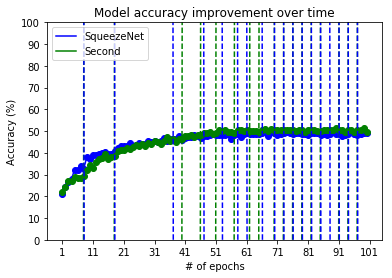

<IPython.core.display.Javascript object>


{SqueezeNet} Test set: Average loss: 1.4143, Accuracy: 4902/10000 (49%)


{Second} Test set: Average loss: 1.3984, Accuracy: 4982/10000 (50%)



In [ ]:
#@title Training
from google.colab import widgets
import matplotlib.pyplot as plt
import numpy as np
import re

grid = widgets.Grid(2, 1)
catch = CatchIO()
find_lr = re.compile("[0-9.e-]*.$")

sec_results = np.full((1+_nb_epochs, 3), np.nan)
if _squeeze_enabled:
    squeeze_results = np.full((1+_nb_epochs, 3), np.nan)
# If _squeeze_results already exists, don't clear it (use existing values)
elif '_squeeze_results' not in vars():
    squeeze_results = np.full((1+_nb_epochs, 3), np.nan)

sec_results[0, 2] = _second_learning_rate
if _squeeze_enabled:
    squeeze_results[0, 2] = _squeeze_learning_rate

# Prepare figure
plot_results_to_grid(grid, (0, 0), sec_results, squeeze_results)

for epoch in range(1, _nb_epochs + 1):
    # Display training output
    with grid.output_to(1, 0):
        if _squeeze_enabled:
            elapsed_time("SqueezeNet", 0)
            #squeeze_sch.step()
            train(squeeze, "SqueezeNet", "cuda", train_loader, squeeze_opt, epoch)
            squeeze_results[epoch-1, :2] = validate(squeeze, "SqueezeNet", "cuda", valid_loader)
            with catch:
                squeeze_sch.step(squeeze_results[epoch-1, 0])
            if catch.buffer is not None and 0 != len(catch.buffer):
                squeeze_results[epoch, 2] = float(find_lr.search(catch.buffer)[0][:-1])
                print('================\n' + catch.buffer + '================\n')
            else:
                squeeze_results[epoch, 2] = squeeze_results[epoch-1, 2]
            elapsed_time("SqueezeNet", 1)
        
        # Second model (ablation/expansion/etc)
        elapsed_time("Second", 0)
        #sec_sch.step()
        train(sec, "Second", "cuda", train_loader, sec_opt, epoch)
        sec_results[epoch-1, :2] = validate(sec, "Second", "cuda", valid_loader)
        with catch:
            sec_sch.step(sec_results[epoch-1, 0])
        if catch.buffer is not None and 0 != len(catch.buffer):
            sec_results[epoch, 2] = float(find_lr.search(catch.buffer)[0][:-1])
            print('================\n' + catch.buffer + '================\n')
        else:
            sec_results[epoch, 2] = sec_results[epoch-1, 2]
        elapsed_time("Second", 1)

    plot_results_to_grid(grid, (0, 0), sec_results, squeeze_results)

    
if _squeeze_enabled:
    squeeze_results[-1, :2] = test(squeeze, "SqueezeNet", "cuda", test_loader)

sec_results[-1, :2] = test(sec, "Second", "cuda", test_loader)

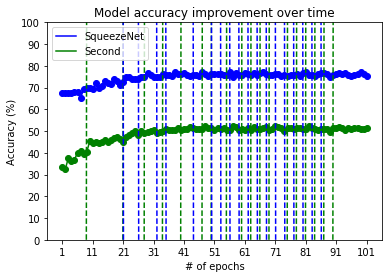

In [ ]:
#@title Results

plot_results(squeeze_results, sec_results)

In [ ]:
#@title Download
from google.colab import files
import datetime
import tarfile
import joblib
import os

try_makedirs('out')

params = \
{
    '_nb_epochs': _nb_epochs,
    '_dataset': _dataset,
    '_interpolation_method': _interpolation_method,
    '_second_version': _second_learning_rate,
    '_second_learning_rate': _second_learning_rate,
    '_second_momentum': _second_momentum,
    '_second_step_size': _second_step_size,
    '_second_weight_decay': _second_weight_decay,
    '_squeeze_enabled': _squeeze_enabled,
    '_squeeze_learning_rate': _squeeze_learning_rate,
    '_squeeze_momentum': _squeeze_momentum,
    '_squeeze_step_size': _squeeze_step_size,
    '_squeeze_weight_decay': _squeeze_weight_decay,
    '_squeeze_pretrained': _squeeze_pretrained
}
joblib.dump(params, 'out/params.joblib')
torch.save(sec.state_dict(), 'out/second.pt')
torch.save(squeeze.state_dict(), 'out/SqueezeNet.pt')
joblib.dump([sec_results, squeeze_results], 'out/results.joblib', compress=3)


output_filename = "squeeze_vs_second_{}_{}_{}.tar.gz".format(
    _second_version, _dataset, datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
)
with tarfile.open(output_filename, "w:gz") as tar:
    outfiles = os.listdir('out')
    for f in outfiles:
        tar.add(os.path.join('out', f))

output_filename = "/gdrive/My Drive/COMP551_Assignment4/squeeze_vs_second_{}_{}_{}.tar.gz".format(
    _second_version, _dataset, datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
)
with tarfile.open(output_filename, "w:gz") as tar:
    outfiles = os.listdir('out')
    for f in outfiles:
        tar.add(os.path.join('out', f))

FileNotFoundError: ignored